In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image, ImageDraw, ImageFont
import json
import random
from clip.model import CLIP_Dense
from clip.simple_tokenizer import SimpleTokenizer
import clip
import os
from tqdm import tqdm
from cj_fonts import inclusive_fonts, fifty_fonts
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize,
    RandomCrop,
    RandomRotation,
    RandomResizedCrop,
)
from torchvision.transforms import Lambda
from torchvision.transforms import functional as F
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_svg import FigureCanvasSVG
import matplotlib.font_manager as font_manager
from matplotlib.font_manager import FontProperties
import PIL

from utils.init_model import (
    load_model,
    my_preprocess,
    preprocess_for_single_character,
    device,
    preprocess,
)
from utils.initialize_font_data import (
    retrieve_font_path,
    exclusive_attributes,
    inclusive_attributes,
    fox_text,
    font_dir,
    cj_font_dir,
    font_paths,
    all_json_path,
    train_json_path,
    test_json_path,
    validation_json_path,
    all_json,
    train_json,
    test_json,
    validation_json,
    train_font_names,
    test_font_names,
    validation_font_names,
    all_gray_scale_image_file_dir,
)
from dataset.dataset import MyDataset, TestDataset, set_image_tensors
from evals.evaluate_tools import (
    evaluate_used_dumped_image_use_score,
    evaluate_use_dumped_image,
    calculate_corr,
)
from utils.transform_image import my_transform

# # If using GPU then use mixed precision training.
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# # Must set jit=False for training
# model_name = "ViT-B/32"
# # model_name = "ViT-L/14"
# model, preprocess = clip.load(model_name, device=device, jit=False)
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

tokenizer = SimpleTokenizer()

norm = preprocess.transforms[-1]
def denormalize(img):
    return (
        img * torch.tensor(norm.std)[:, None, None]
        + torch.tensor(norm.mean)[:, None, None]
    )

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt
exclusive_attributes:  ['capitals', 'monospace']


In [2]:
fifty_font_paths = [os.path.join(cj_font_dir, f) for f in fifty_fonts.split('\n') if f != '']

# add font
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
for font in font_manager.findSystemFonts(cj_font_dir):
    font_manager.fontManager.addfont(font)

ttf_list = font_manager.fontManager.ttflist

# count font number
train_font_num = len(list(json.load(open(train_json_path, 'r')).keys()))
print(train_font_num)

validation_font_num = len(list(json.load(open(validation_json_path, 'r')).keys()))
print(validation_font_num)

test_font_num = len(list(json.load(open(test_json_path, 'r')).keys()))
print(test_font_num)

120
40
40


In [3]:
alphabet_text = 'ABCD\nEFGH\nIJKL\nMNOP\nQRST\nUVWX\nYZ'
texts_for_font_image = [fox_text]

target_attributes = ['thin']

In [4]:
tmp_fox_text = 'The quick brown\nfox jumps over\nthe lazy dog\nTHE QUICK BROWN'
tmp_fox_text = 'The quick\nbrown fox\njumps over\nthe lazy dog'
texts_for_font_image = [tmp_fox_text]
# texts_for_font_image = ['A', 'B']

In [5]:
image_file_dir = None
image_file_dir = all_gray_scale_image_file_dir
char_size = 250
tmp_preprocess = preprocess_for_single_character
tmp_preprocess = my_preprocess
# tmp_preprocess = my_transform()

dump_image = True
single_character = False
dataset = MyDataset(
    font_dir, 
    train_json_path, 
    texts_for_font_image, 
    use_negative = True,
    use_weight=False,
    use_score=False,
    use_multiple_attributes=True,
    use_random_attributes=True,
    random_prompts_num=100,
    max_sample_num=3,
    rich_prompt=False,
    sample_num_each_epoch=1,
    image_file_dir=image_file_dir,
    attribute_threshold=50, 
    attribute_under_threshold=50,
    preprocess=tmp_preprocess,
    dump_image=dump_image, 
    exclusive_attributes=exclusive_attributes,
    geta=1.0,
    single_character=single_character, 
    use_negative_loss=True,
    use_contrastive_image_loss=True,
    use_vae_loss=True,
    store_unnormalized_image=False, 
    n_px_of_unnormalized_image=64,
    use_clip_like_format=False, 
    char_size=char_size, 
    context_length=77,
)
set_image_tensors(
    dataset, preprocess=tmp_preprocess, sample_num=5, color_jitter_sample_num=5,
)

test_data = TestDataset(font_dir, validation_json_path, texts_for_font_image, char_size=char_size, attribute_threshold=0, target_attributes=target_attributes, preprocess=preprocess, single_character=single_character, image_file_dir=image_file_dir, use_clip_like_format=False)
#set_image_tensors(dataset, sample_num=10)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False)
it = iter(data_loader)
test_it = iter(test_data_loader)

100%|██████████| 120/120 [00:01<00:00, 102.83it/s]


load image tensors from image files ...


100%|██████████| 120/120 [00:46<00:00,  2.59it/s]


In [6]:
target_attributes = ['thin', 'happy']
test_data = TestDataset(font_dir, validation_json_path, texts_for_font_image, char_size=256, target_attributes=target_attributes, preprocess=preprocess, single_character=single_character, use_clip_like_format=False, image_file_dir=None)
images, texts = next(test_it)
int_text = [int(token) for token in texts[0]]
tokenizer.decode(int_text)
batch = next(it)
print(len(batch))

7


<|startoftext|>playful , disorderly , delicate font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


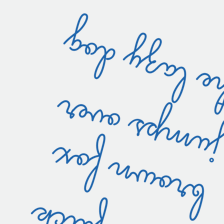

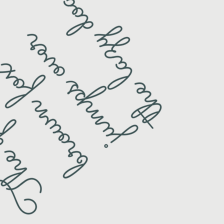

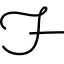

tensor(7)
<|startoftext|>thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


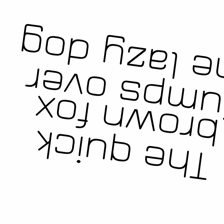

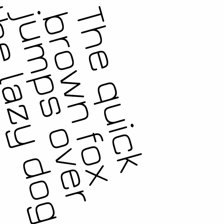

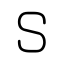

tensor(18)
<|startoftext|>attention - grabbing , friendly font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


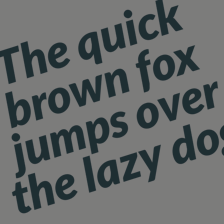

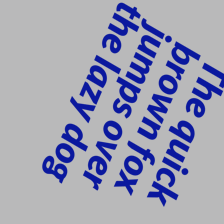

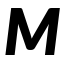

tensor(12)
<|startoftext|>calm , not happy , not display font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


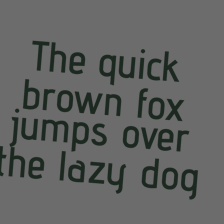

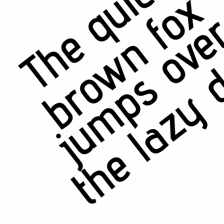

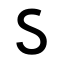

tensor(18)
<|startoftext|>not clumsy , not thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


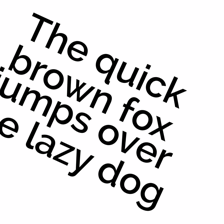

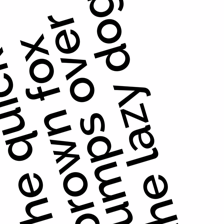

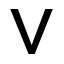

tensor(21)
<|startoftext|>sharp , not artistic , fresh font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


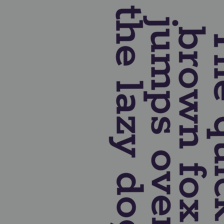

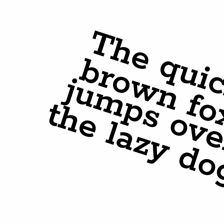

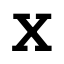

tensor(23)
<|startoftext|>not technical , not italic , calm font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


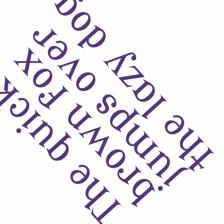

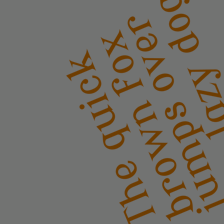

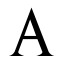

tensor(0)
<|startoftext|>gentle , friendly font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


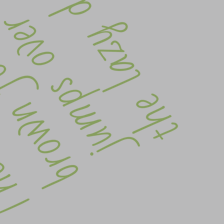

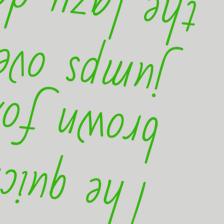

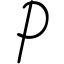

tensor(15)
<|startoftext|>warm , not clumsy font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


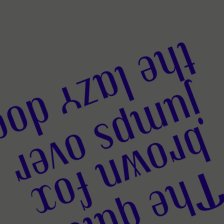

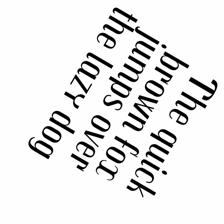

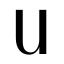

tensor(20)
<|startoftext|>complex font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


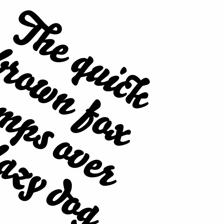

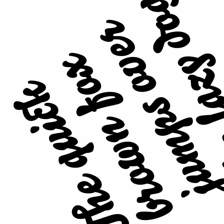

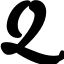

tensor(16)
<|startoftext|>not playful , attention - grabbing font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 64, 64])


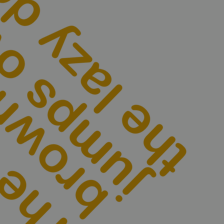

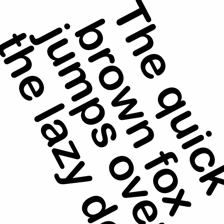

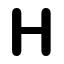

tensor(7)


In [9]:
count = 0
for batch in it:
  images, images_2, texts, font_indices, attribute_indices, vae_target_character, vae_one_hot_vector = batch
  int_text = [int(token) for token in texts[0]]
  text = tokenizer.decode(int_text)
  print(text)
  print(images.shape)
  print(vae_target_character.shape)
  display(to_pil_image(denormalize(images[0])))
  display(to_pil_image(denormalize(images_2[0])))
  display(to_pil_image(vae_target_character[0]))
  print(torch.argmax(vae_one_hot_vector[0]))
  count += 1
  if count > 10:
    break

In [9]:
image_features = model.encode_image(images.to(device))
image_features_contrastive = model.encode_image(images_2.to(device))
d1 = torch.abs(image_features - image_features_contrastive)
# slide batch of image_features_contrastive
d2 = torch.abs(image_features - torch.roll(
    image_features_contrastive, 1, dims=0
))
torch.max(
    torch.tensor(0.0, device=device),
    d1 - d2 + 0.05,
)

In [13]:
print(image_features)
print(torch.roll(image_features, 1, dims=0))

tensor([[-0.4971, -0.0861, -0.3782,  ...,  0.6426, -0.1877, -0.0467],
        [-0.1846,  0.4814, -0.2241,  ...,  0.5503, -0.1093, -0.0741]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
tensor([[-0.1846,  0.4814, -0.2241,  ...,  0.5503, -0.1093, -0.0741],
        [-0.4971, -0.0861, -0.3782,  ...,  0.6426, -0.1877, -0.0467]],
       device='cuda:0', dtype=torch.float16, grad_fn=<RollBackward0>)


In [12]:
batch = next(it)

<|startoftext|>thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([16, 3, 224, 224])


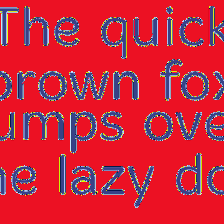

<|startoftext|>thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([16, 3, 224, 224])


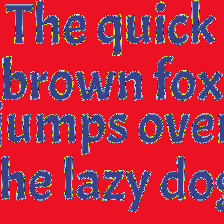

<|startoftext|>thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([8, 3, 224, 224])


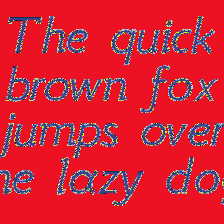

In [16]:
count = 0
test_it = iter(test_data_loader)
for images, texts in test_it:
  int_text = [int(token) for token in texts[0]]
  text = tokenizer.decode(int_text)
  print(text)
  print(images.shape)
  display(to_pil_image(images[0]))
  count += 1
  if count > 3:
    break

<|startoftext|>thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


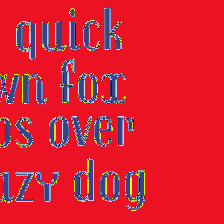

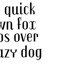

<|startoftext|>soft , artistic font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


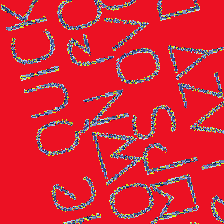

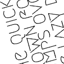

<|startoftext|>not wide font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


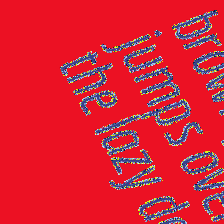

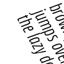

<|startoftext|>legible , bad font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


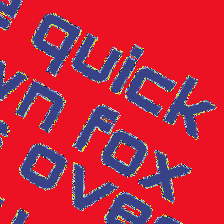

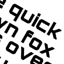

<|startoftext|>fresh , not attention - grabbing , delicate font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


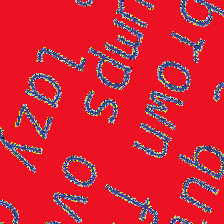

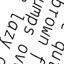

<|startoftext|>happy , dramatic font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


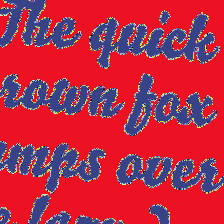

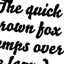

<|startoftext|>not artistic , strong font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


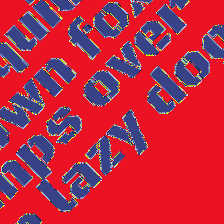

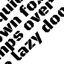

<|startoftext|>not dramatic , charming font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


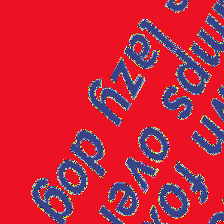

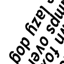

<|startoftext|>disorderly font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


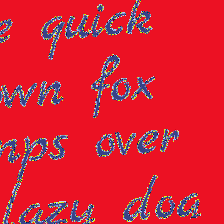

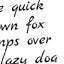

<|startoftext|>not attractive font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


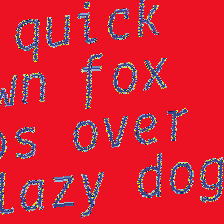

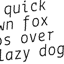

<|startoftext|>calm , not soft , not sloppy font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.Size([2, 3, 224, 224])


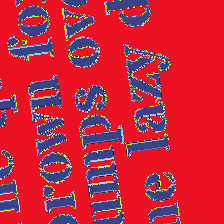

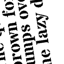

In [12]:
count = 0
for images, unnormalized_images, texts in it:
  int_text = [int(token) for token in texts[0]]
  text = tokenizer.decode(int_text)
  print(text)
  print(images.shape)
  display(to_pil_image(images[0]))
  display(to_pil_image(unnormalized_images[0]))
  count += 1
  if count > 10:
    break


In [11]:
1

1

<|startoftext|>thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


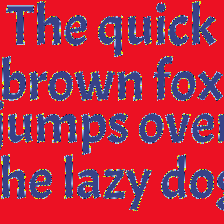

<|startoftext|>thin font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


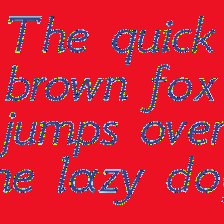

In [24]:
count = 0
for images, texts in test_it:
  int_text = [int(token) for token in texts[0]]
  text = tokenizer.decode(int_text)
  print(text)
  display(to_pil_image(images[0]))
  count += 1
  if count > 10:
    break


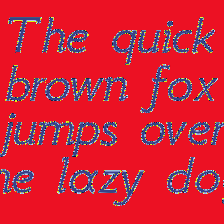

In [27]:
display(to_pil_image(images[0]))

In [28]:
image_file_dir = None
image_file_dir = '../attributeData/grayscale_images'
test_datasets = [TestDataset(font_dir, test_json_path, texts_for_font_image, target_attributes=[target_attribute], preprocess=preprocess, dump_image=True, image_file_dir=image_file_dir) for target_attribute in inclusive_attributes]
checkpoint_paths = [\
    'model_checkpoints/3_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
    #'model_checkpoints/new_best_fox_negative_91011_1011_use_weight_ex.pt',
    #'model_checkpoints/new_best_fox_negative_91011_1011_use_weight_image_file_dir_ex.pt',
    #'model_checkpoints/one_leave_out_happy_91011_91011_image_file_dir_all_aug_ex.pt'
    #'model_checkpoints/best_fox_negative_91011_1011_use_weight_ex_2e5.pt'
    ]
for checkpoint_path in checkpoint_paths:
    model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
    #corr, result = evaluate(model, texts_for_font_image, test_json_path, inclusive_attributes, font_dir)
    corr, result = evaluate_use_dumped_image(model, test_datasets, inclusive_attributes)
    print(corr)

KeyboardInterrupt: 

# Evaluate Model

In [ ]:
checkpoint_path = 'model_checkpoints/3_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
corrs = []
for target_attribute in inclusive_attributes:
    #checkpoint_path = f'model_checkpoints/one_leave_out_{target_attribute}_91011_91011_image_file_dir_all_aug_ex.pt'
    #checkpoint_path = 'model_checkpoints/67891011_891011_multiple_3_1000_image_file_dir_aug_ex.pt'
    #if not os.path.exists(checkpoint_path):
    #    continue
    target_attributes = [target_attribute]
    image_file_dir = '../attributeData/grayscale_images'
    dump_image = True
    single_character = False
    use_score = True
    test_data = TestDataset(font_dir, validation_json_path, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=target_attributes, preprocess=preprocess, single_character=single_character, image_file_dir=image_file_dir)

    #corr, result = evaluate(model, texts_for_font_image, test_json_path, inclusive_attributes, font_dir)
    corr, result = evaluate_use_dumped_image(model, [test_data], target_attributes)
    corrs.append(corr)
    print(target_attribute, corr)

# mean
print('mean: ', np.mean(corrs))
# std
print('std: ', np.std(corrs))

angular 0.6188546173184573
artistic 0.9159278064374556
attention-grabbing 0.8048627370350113
attractive 0.7992277517522639
bad 0.8005764070136712
boring 0.6148980334181615
calm 0.4715833110031693
charming 0.659121773350095
clumsy 0.7477020081066801
complex 0.876087889913935
delicate 0.7401886421574034
disorderly 0.7516796689666151
dramatic 0.910082685961674
formal 0.333332965235934
fresh 0.24131156124857087
friendly 0.5246263360722643
gentle 0.6142510714900928
graceful 0.6888069200005766


happy 0.7797915759517635
legible 0.5405677777400218
modern 0.8414325809657717
playful 0.8857677614357637
pretentious 0.8425345714331405
sharp 0.5077737316572336
sloppy 0.8646639904547916
soft 0.8048206508606074
strong 0.845314077042142
technical 0.7905388632776467
thin 0.8742030206014637
warm 0.681483496157715
wide 0.5863542441920182
mean:  0.7083344686532939
std:  0.16679750934999737


In [ ]:
#checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_1011_use_weight_image_file_dir_ex.pt'
checkpoint_path = 'model_checkpoints/91011_1011_use_weight_aug_ex.pt'
checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_91011_multiple_3_1000_aug_ex.pt'
checkpoint_path = None
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
image_file_dir = '../attributeData/grayscale_images'
image_file_dir = None

tmp_text = fox_text
tmp_texts_for_font_image = [tmp_text]

tmp_test_json_path = validation_json_path
corrs = []
for target_attribute in inclusive_attributes:
    #checkpoint_path = f'model_checkpoints/one_leave_out_{target_attribute}_91011_91011_image_file_dir_all_aug_ex.pt'
    #checkpoint_path = 'model_checkpoints/67891011_891011_multiple_3_1000_image_file_dir_aug_ex.pt'
    #if not os.path.exists(checkpoint_path):
    #    continue
    target_attributes = [target_attribute]
    dump_image = True
    single_character = False
    use_score = True
    test_data = TestDataset(font_dir, tmp_test_json_path, tmp_texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=target_attributes, preprocess=preprocess, single_character=single_character, image_file_dir=image_file_dir)

    #corr, result = evaluate(model, texts_for_font_image, test_json_path, inclusive_attributes, font_dir)
    corr, result = evaluate_use_dumped_image(model, [test_data], target_attributes)
    corrs.append(corr)
    print(target_attribute, corr)

# mean
print('mean: ', np.mean(corrs))
# std
print('std: ', np.std(corrs))

angular 0.3603790929401411
artistic 0.3161383373630063
attention-grabbing 0.14027868575925884
attractive 0.11327442889655105
bad -0.26486398059989347
boring -0.3289026554026853
calm 0.07032041046642008
charming 0.36561578442416187
clumsy 0.3549645283128474
complex -0.1072938119005617
delicate 0.26110234847037994
disorderly 0.31566780357499524
dramatic 0.4612797904470125
formal -0.2507649133370169
fresh 0.1486086854229852
friendly 0.35040610504552533
gentle 0.2861382645130486
graceful 0.35545845583570757
happy 0.11195867192697125
legible -0.021172661081546324
modern 0.04261132448141529
playful 0.2877668870212537
pretentious 0.3109200069143965
sharp 0.03422273133543552
sloppy 0.14267376220440495
soft 0.12613507543748867
strong 0.26466708201119277
technical -0.03536804334043614
thin 0.011284440466033508
warm 0.2629983203963998
wide 0.11782485797440735
mean:  0.1485267682573968
std:  0.19803006296750686


In [ ]:
corrs = []
for target_attribute in inclusive_attributes:
    checkpoint_path = f'model_checkpoints/one_leave_out_{target_attribute}_91011_91011_image_file_dir_all_aug_ex.pt'
    #checkpoint_path = 'model_checkpoints/67891011_891011_multiple_3_1000_image_file_dir_aug_ex.pt'
    if not os.path.exists(checkpoint_path):
        continue
    target_attributes = [target_attribute]
    image_file_dir = '../attributeData/grayscale_images'
    dump_image = True
    single_character = False
    use_score = True
    test_data = TestDataset(font_dir, validation_json_path, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=target_attributes, preprocess=preprocess, single_character=single_character, image_file_dir=image_file_dir)

    model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
    #corr, result = evaluate(model, texts_for_font_image, test_json_path, inclusive_attributes, font_dir)
    corr, result = evaluate_use_dumped_image(model, [test_data], target_attributes)
    print(target_attribute, corr)
    corrs.append(corr)

# mean
print('mean: ', np.mean(corrs))
# std
print('std: ', np.std(corrs))

mean:  nan
std:  nan


/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: -item[1])}
for k, v in sorted_result.items():
    print(f'{k}: {v}')
print(sorted_result['happy'])

delicate: 0.7093871188854776
artistic: 0.5557151125114874
dramatic: 0.45330693529614235
graceful: 0.41432414705472675
playful: 0.4068071988287895
charming: 0.38524257113155264
gentle: 0.3835428461131033
pretentious: 0.27909697175296216
clumsy: 0.19910732657507868
soft: 0.19790873538067733
friendly: 0.17435148964538155
modern: 0.16262175757636071
sharp: 0.14149973285181755
happy: 0.1142742070610998
thin: 0.11331327373245463
disorderly: 0.08140433567972716
fresh: 0.07908915073377344
strong: 0.06855757401945771
angular: 0.06443658560767163
sloppy: 0.06201868159728023
attractive: 0.05382254645530861
attention-grabbing: 0.031785032054283256
warm: 0.025435014565660632
calm: -0.06987169991191855
formal: -0.07867910031758188
technical: -0.157674009158249
complex: -0.16844278391606385
bad: -0.1922736690411274
wide: -0.24525641057542952
boring: -0.34057748849246605
legible: -0.405190895421566
0.1142742070610998


In [ ]:
def show_corr_figure(model, json_path, target_attribute, text='A', save_fig=False, fig_size=(5,5), red_font_paths=None):
    dataset = TestDataset(font_dir, json_path, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=[target_attribute], preprocess=preprocess, image_file_dir=image_file_dir)
    corr, cos_sim, ground_truth, variance_of_embedded_images = calculate_corr(model, dataset, return_variance=True)
    print(torch.sum(variance_of_embedded_images))

    fig, ax = plt.subplots(figsize=fig_size)

    ax.scatter(ground_truth, cos_sim, alpha=0.0)
    #ax.set_title(f'Correlation coefficient: {target_attribute}')
    ax.set_title(f'{target_attribute}')
    #ax.set_xlabel('Ground truth')
    #ax.set_ylabel('Cosine similarity Predicted by CLIP')

    font_paths = dataset.font_paths

    if red_font_paths is None:
        red_font_paths = []
    for i, font_path in enumerate(font_paths):
        red_flag = False
        if font_path in red_font_paths:
            red_flag = True

        font_name = os.path.splitext(os.path.basename(font_path))[0]
        for ttf in ttf_list:
            if font_name in str(ttf):
                mpl.rcParams['font.family'] = ttf.name
                ax.annotate(text, (ground_truth[i], cos_sim[i]), fontsize=25, c='red' if red_flag else 'black')
    if save_fig:
        plt.savefig(f'../attributeData/plt_outputs/clip_{target_attribute}_{text}.svg')
    plt.show()

tensor(0.5562, dtype=torch.float16)


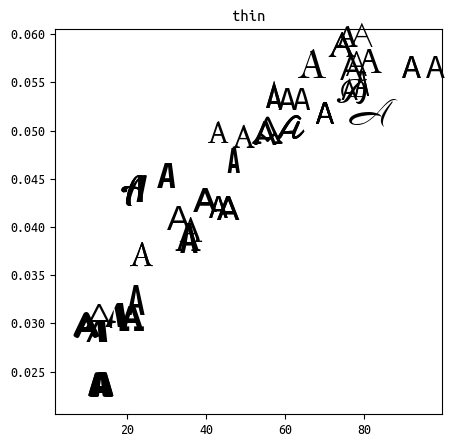

In [ ]:
checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_91011_multiple_3_1000_aug_ex.pt'
#checkpoint_path = 'model_checkpoints/3_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
show_corr_figure(model, test_json_path, 'thin', text='A', save_fig=True)

tensor(0.3354, dtype=torch.float16)


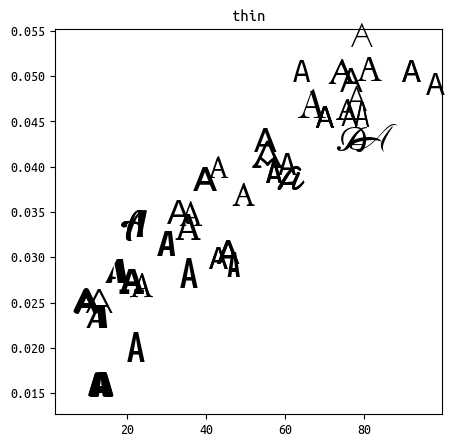

In [ ]:
#checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_91011_multiple_3_1000_aug_ex.pt'
checkpoint_path = 'model_checkpoints/3_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
show_corr_figure(model, test_json_path, 'thin', text='A', save_fig=True)

tensor(8.5547, dtype=torch.float16)


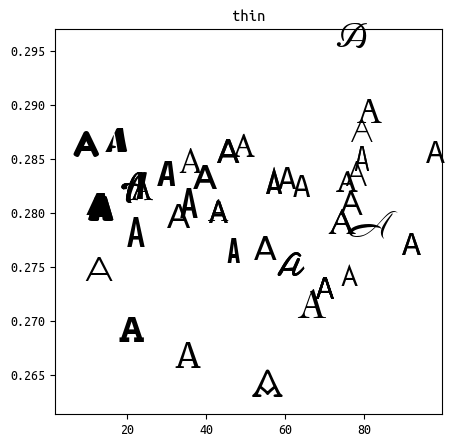

In [ ]:
#checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_91011_multiple_3_1000_aug_ex.pt'
checkpoint_path = 'model_checkpoints/3_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
checkpoint_path = None
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
show_corr_figure(model, test_json_path, 'thin', text='A', save_fig=True)

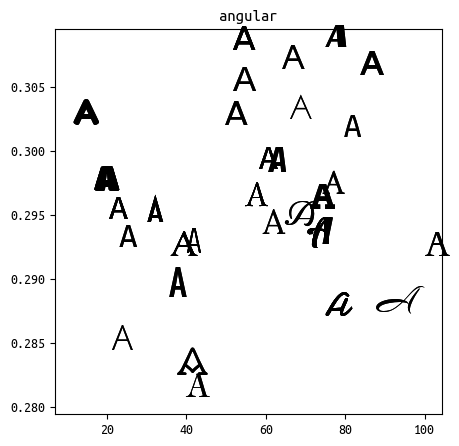

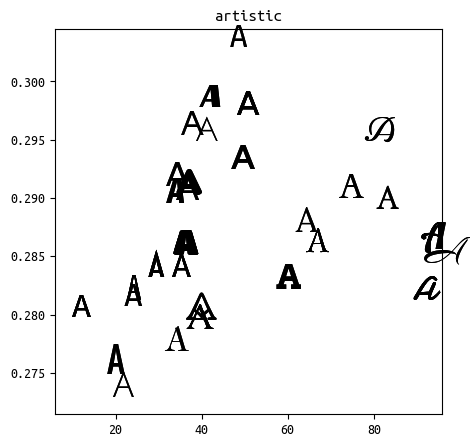

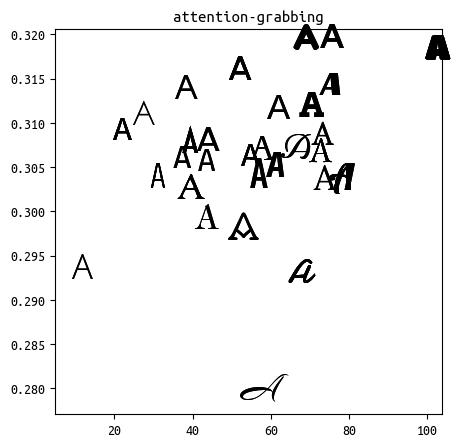

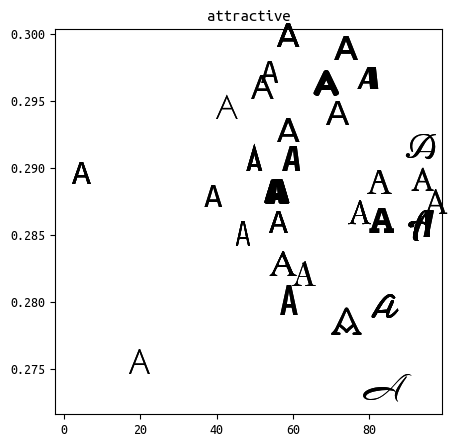

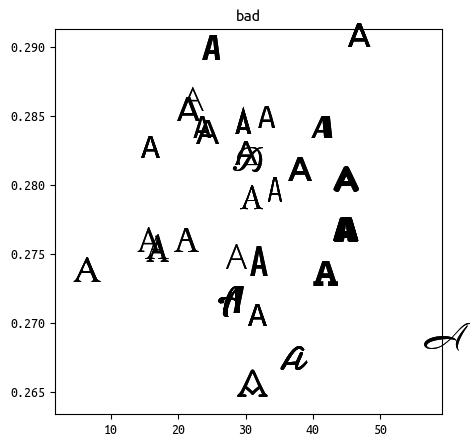

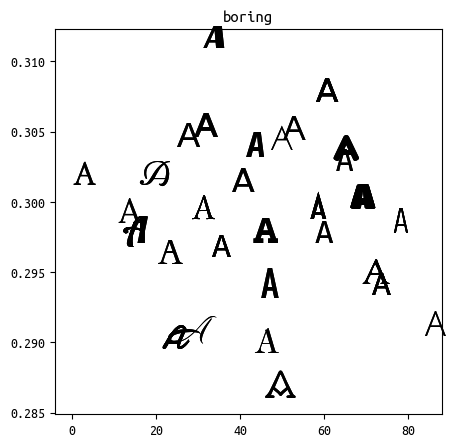

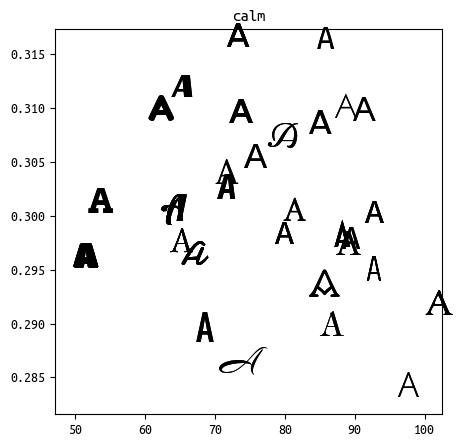

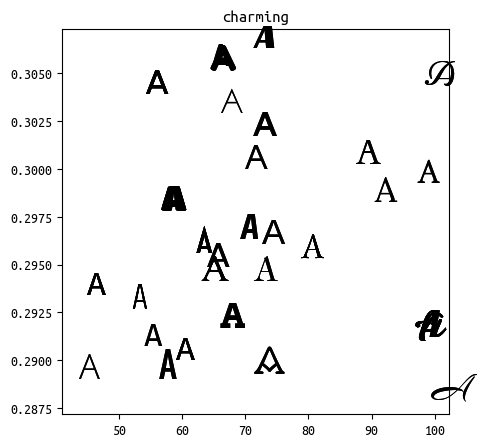

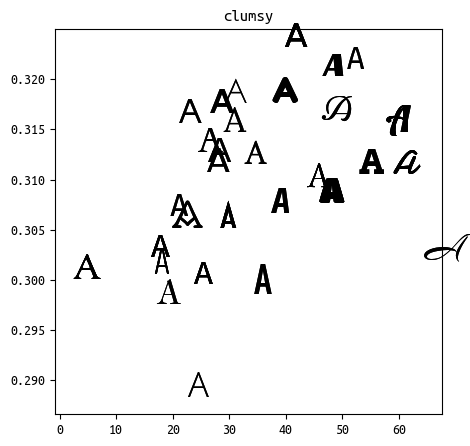

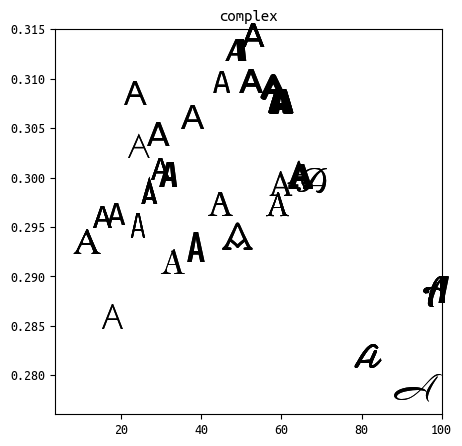

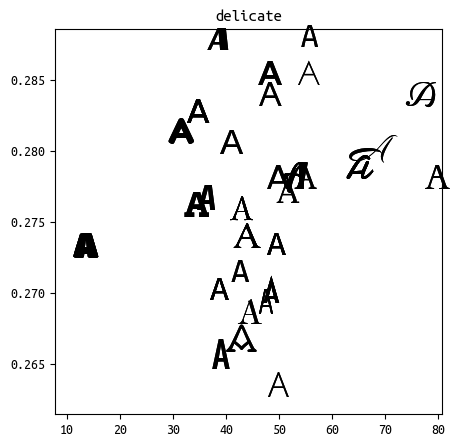

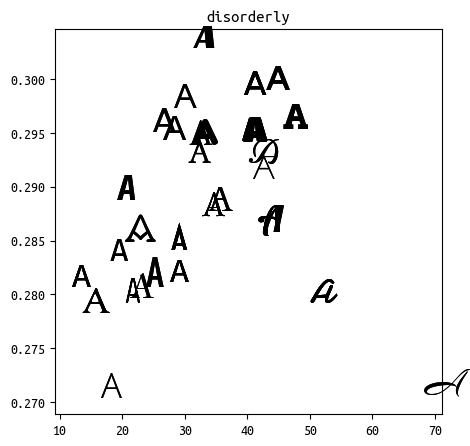

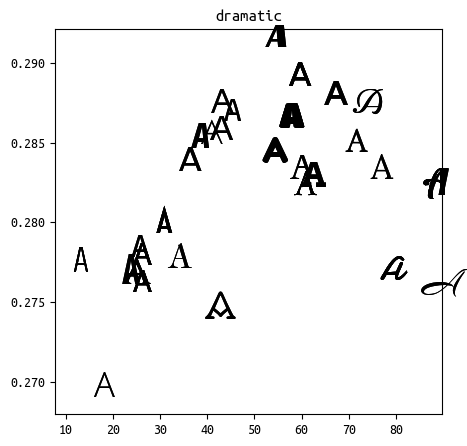

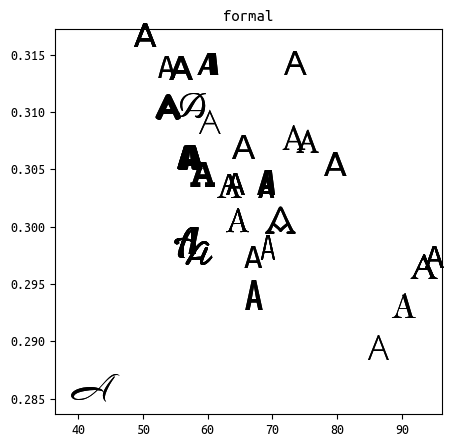

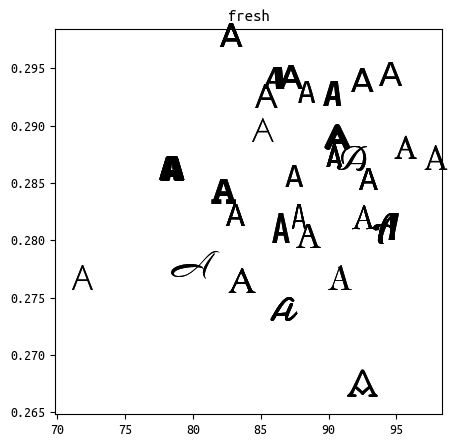

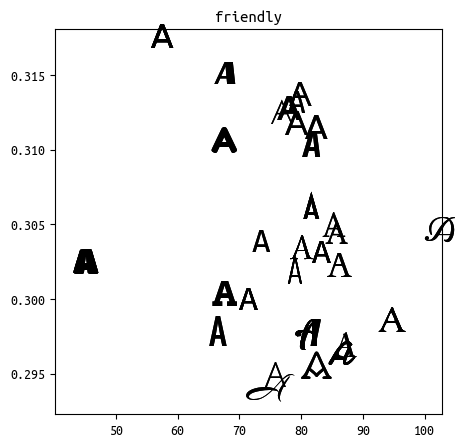

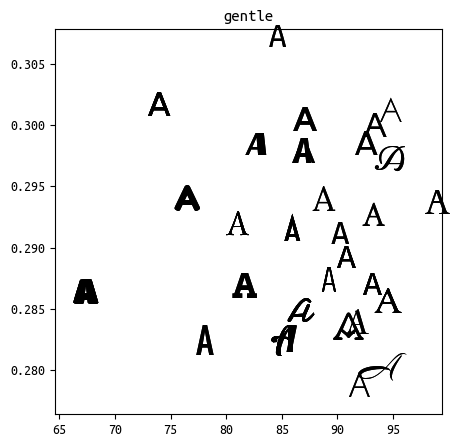

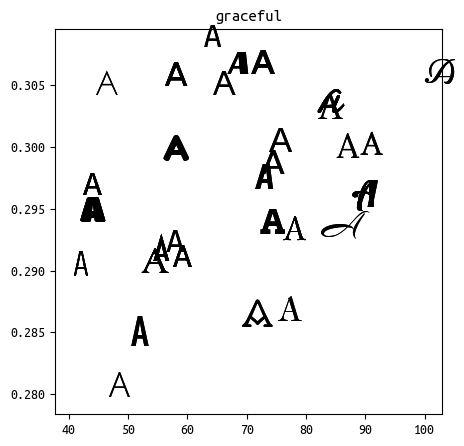

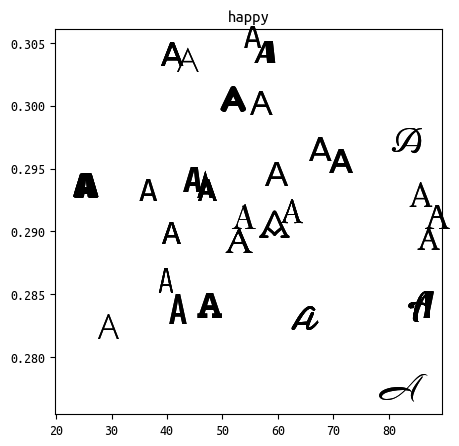

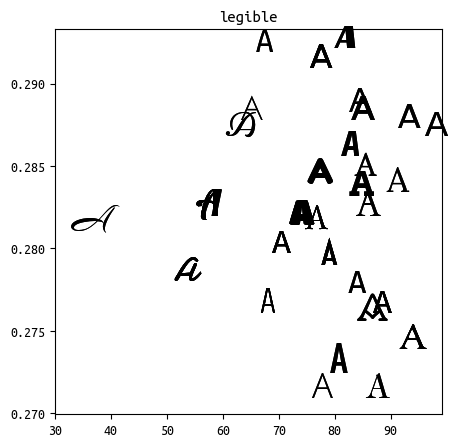

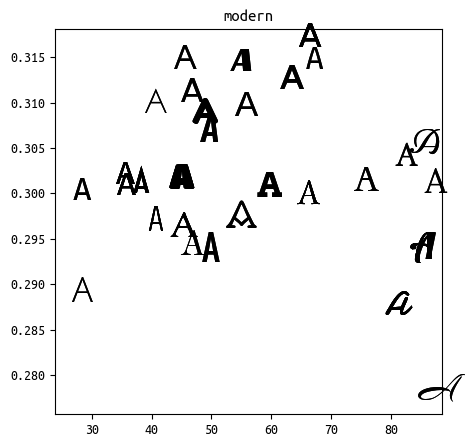

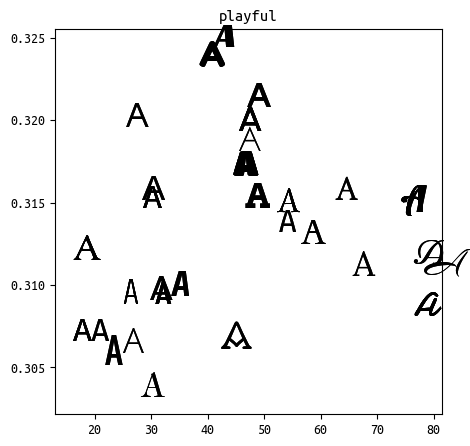

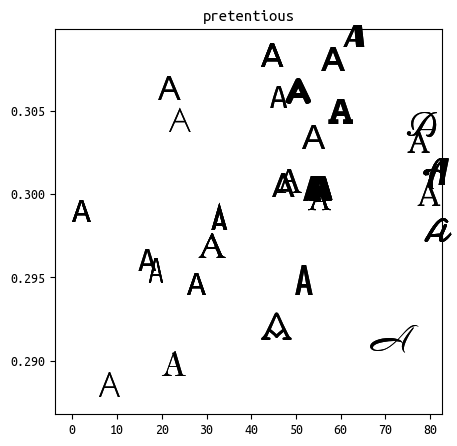

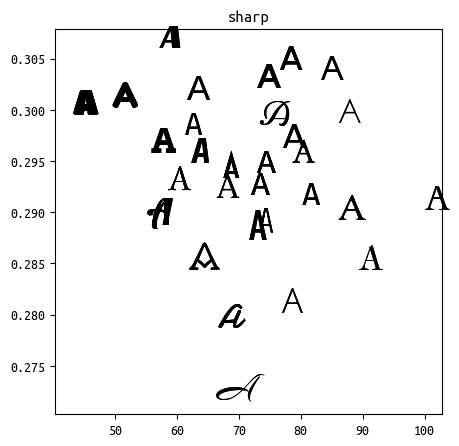

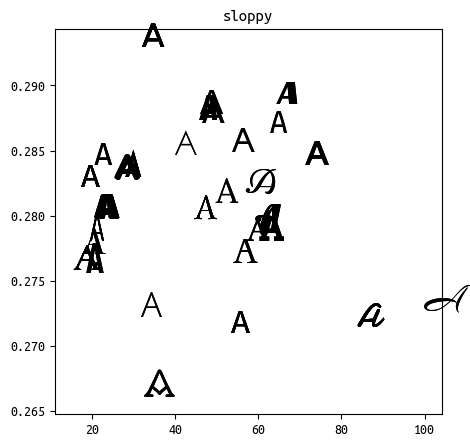

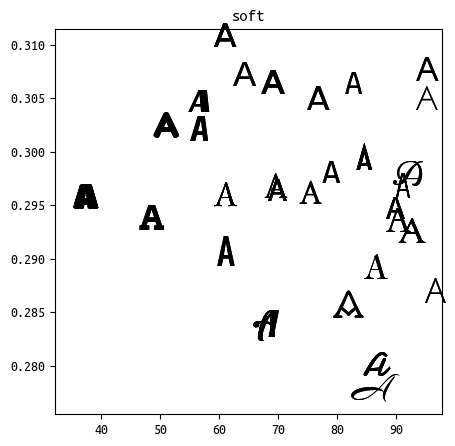

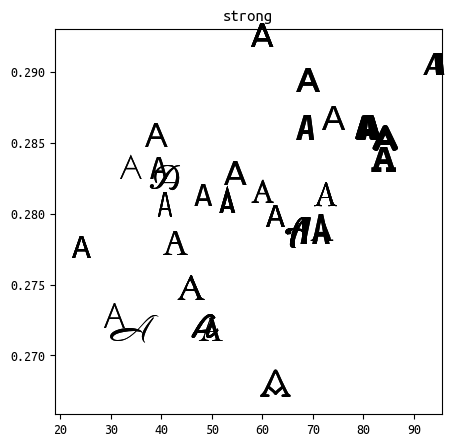

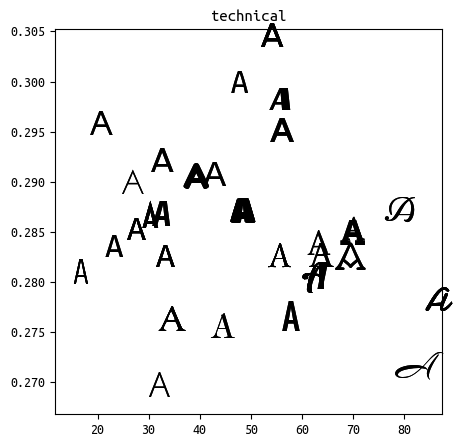

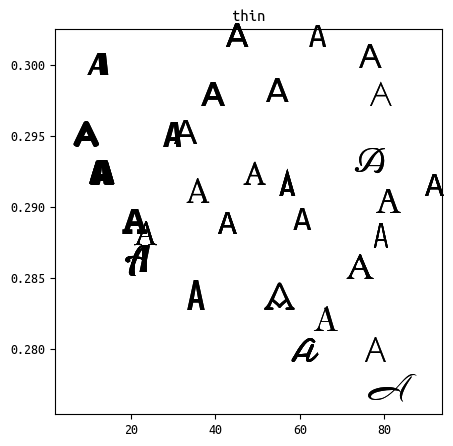

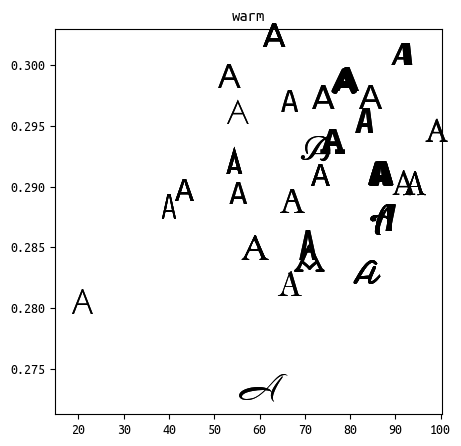

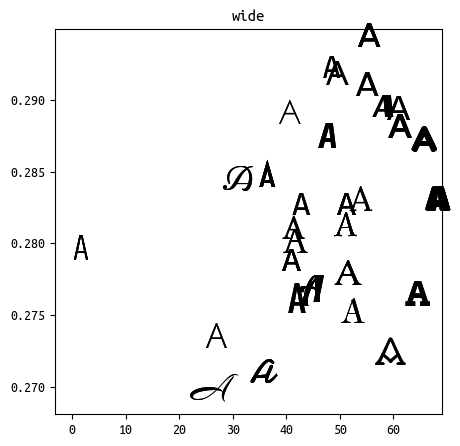

In [ ]:
checkpoint_path = None
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
for attribute in inclusive_attributes:
    show_corr_figure(model, test_json_path, attribute, text='A', save_fig=True)

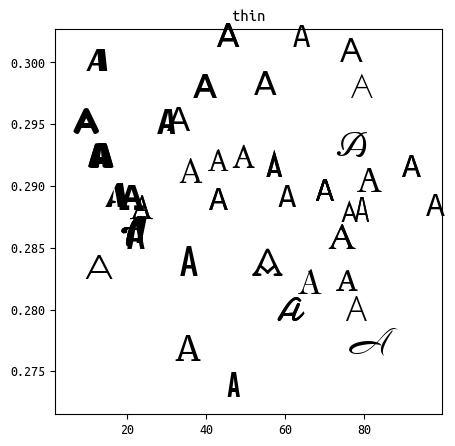

In [ ]:
checkpoint_path = None
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
show_corr_figure(model, test_json_path, 'thin', text='A', save_fig=True)

# Sort Cos Sim for Target Font

In [ ]:
def create_image(text, font_path, image_file_dir=None, char_size=150):
    if image_file_dir is not None:
        image_path = os.path.join(image_file_dir, f'{os.path.splitext(os.path.basename(font_path))[0]}.png')
        if os.path.exists(image_path):
            return Image.open(image_path)

    line_num = text.count('\n') + 1
    # print(line_num)
    width = int(char_size * len(text) * 1.8 / line_num)
    height = int(char_size * 1.5) * line_num
    font = ImageFont.truetype(font_path, char_size)

    image = draw_text_with_new_lines(text, font, width, height)
    return image

def sort_attribute_by_cos_sim(target_font_path, text, target_attributes, model):
    image = create_image(text, target_font_path)
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)
    embedded_image = model.encode_image(preprocessed_image)
    embedded_texts = None
    for attribute in target_attributes:
        attribute_query = f'{attribute} font'
        embedded_text = model.encode_text(clip.tokenize(attribute_query).to(device))
        if embedded_texts is None:
            embedded_texts = embedded_text
        else:
            embedded_texts = torch.cat((embedded_texts, embedded_text), dim=0)

    # calculate cosine similarity
    cos_sim = nn.functional.cosine_similarity(embedded_image, embedded_texts, dim=-1)
    cos_sim_numpy = cos_sim.cpu().detach().numpy()
    sorted_index = np.argsort(cos_sim_numpy)[::-1]

    sorted_attributes = [target_attributes[i] for i in sorted_index]
    return sorted_attributes

def sort_attribute_by_cos_sim_ranking_for_multiple_fonts(target_font_path, target_font_paths, text, target_attributes, model):
    dataset = TestDataset(target_font_paths, None, [text], target_attributes, dump_image=True)




In [ ]:
checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_91011_multiple_3_1000_aug_ex.pt'
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)

In [ ]:
text = 'A'
target_font_path = '../gwfonts/Arimo-Bold.ttf'
target_font_name = os.path.splitext(os.path.basename(target_font_path))[0]
sorted_attributes = sort_attribute_by_cos_sim(target_font_path, 'A', inclusive_attributes, model)
print(sorted_attributes)

['boring', 'bad', 'gentle', 'thin', 'legible', 'warm', 'strong', 'sharp', 'friendly', 'wide', 'soft', 'fresh', 'calm', 'formal', 'sloppy', 'charming', 'attractive', 'graceful', 'delicate', 'angular', 'technical', 'clumsy', 'pretentious', 'attention-grabbing', 'modern', 'disorderly', 'dramatic', 'happy', 'complex', 'artistic', 'playful']


In [ ]:
gt_attribute_scores = all_json[target_font_name]
sorted_gt_attribute_scores = sorted(gt_attribute_scores.items(), key=lambda x: -float(x[1]))

In [ ]:
sorted_gt_attribute_scores

[('legible', '97.81'),
 ('fresh', '94.09'),
 ('gentle', '86.36'),
 ('formal', '81.34'),
 ('friendly', '75.07'),
 ('strong', '73.52'),
 ('warm', '72.27'),
 ('calm', '70.3'),
 ('graceful', '65.53'),
 ('attractive', '64.77'),
 ('charming', '61.67'),
 ('soft', '60.35'),
 ('attention-grabbing', '60.1'),
 ('wide', '58.04'),
 ('sharp', '54.26'),
 ('boring', '50.94'),
 ('pretentious', '46.79'),
 ('happy', '41.57'),
 ('modern', '35.23'),
 ('dramatic', '28.64'),
 ('delicate', '28.35'),
 ('thin', '27.24'),
 ('technical', '25.11'),
 ('angular', '24.37'),
 ('complex', '18.56'),
 ('playful', '17.69'),
 ('bad', '17.04'),
 ('disorderly', '16.86'),
 ('clumsy', '16'),
 ('artistic', '13.31'),
 ('sloppy', '11.46'),
 ('serif', '9.63'),
 ('italic', '9.34'),
 ('display', '6.76'),
 ('cursive', '4.3'),
 ('capitals', '0'),
 ('monospace', '0')]

# Evaluate Test Fonts

In [ ]:
json_path = test_json_path
data_json = json.load(open(json_path, 'r'))
all_font_paths = [os.path.join(font_dir, font_path) for font_path in os.listdir(font_dir)]
font_names = list(data_json.keys())
font_paths = []
for font_name in font_names:
    flag = False
    for font_path in all_font_paths:
        if font_name == os.path.splitext(os.path.basename(font_path))[0]:
            if flag:
                print(f'{font_name}, {font_path}')
            font_paths.append(font_path)
            flag = True

## show ground truth

In [ ]:
target_attribute = 'boring'
font_name_to_index = {font_name: i for i, font_name in enumerate(font_names)}
attribute_scores = [float(data_json[font_name][target_attribute]) for font_name in font_names]
sorted_index = np.argsort(attribute_scores)

In [ ]:
text = 'A'
fig_size = (30, 30)

fig, ax = plt.subplots(figsize=fig_size)
ys = [10] * len(sorted_index)
ax.scatter(sorted_index, ys, alpha=0.0)
#ax.set_title(f'Correlation coefficient: {target_attribute}')
ax.set_title(f'{target_attribute}')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Cosine similarity Predicted by CLIP')
my_font = FontProperties()

for i, j in enumerate(sorted_index):
    font_path = font_paths[j]
    font_index = font_name_to_index[os.path.splitext(os.path.basename(font_path))[0]]
    font_base_name = os.path.basename(font_path)
    my_font.set_file(font_path)
    ax.annotate(text, (i, ys[font_index]), fontsize=25, fontproperties=my_font)

plt.savefig(f'{target_attribute}.png')
plt.show()


## show predicted

In [ ]:
texts_for_font_image = [fox_text]
target_attribute = 'thin'
target_attributes = [target_attribute]
data = TestDataset(font_paths, None, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=target_attributes)

No json path, use predict mode.


In [ ]:
model = load_model(model, checkpoint_path='model_checkpoints/best_fox_negative_91011_1011_use_weight_ex_2e5.pt', requires_grad=False)
tmp_cos_sim = calculate_corr(model, data, predict_mode=True)
sorted_index = np.argsort(tmp_cos_sim)
cos_sim = sorted_index

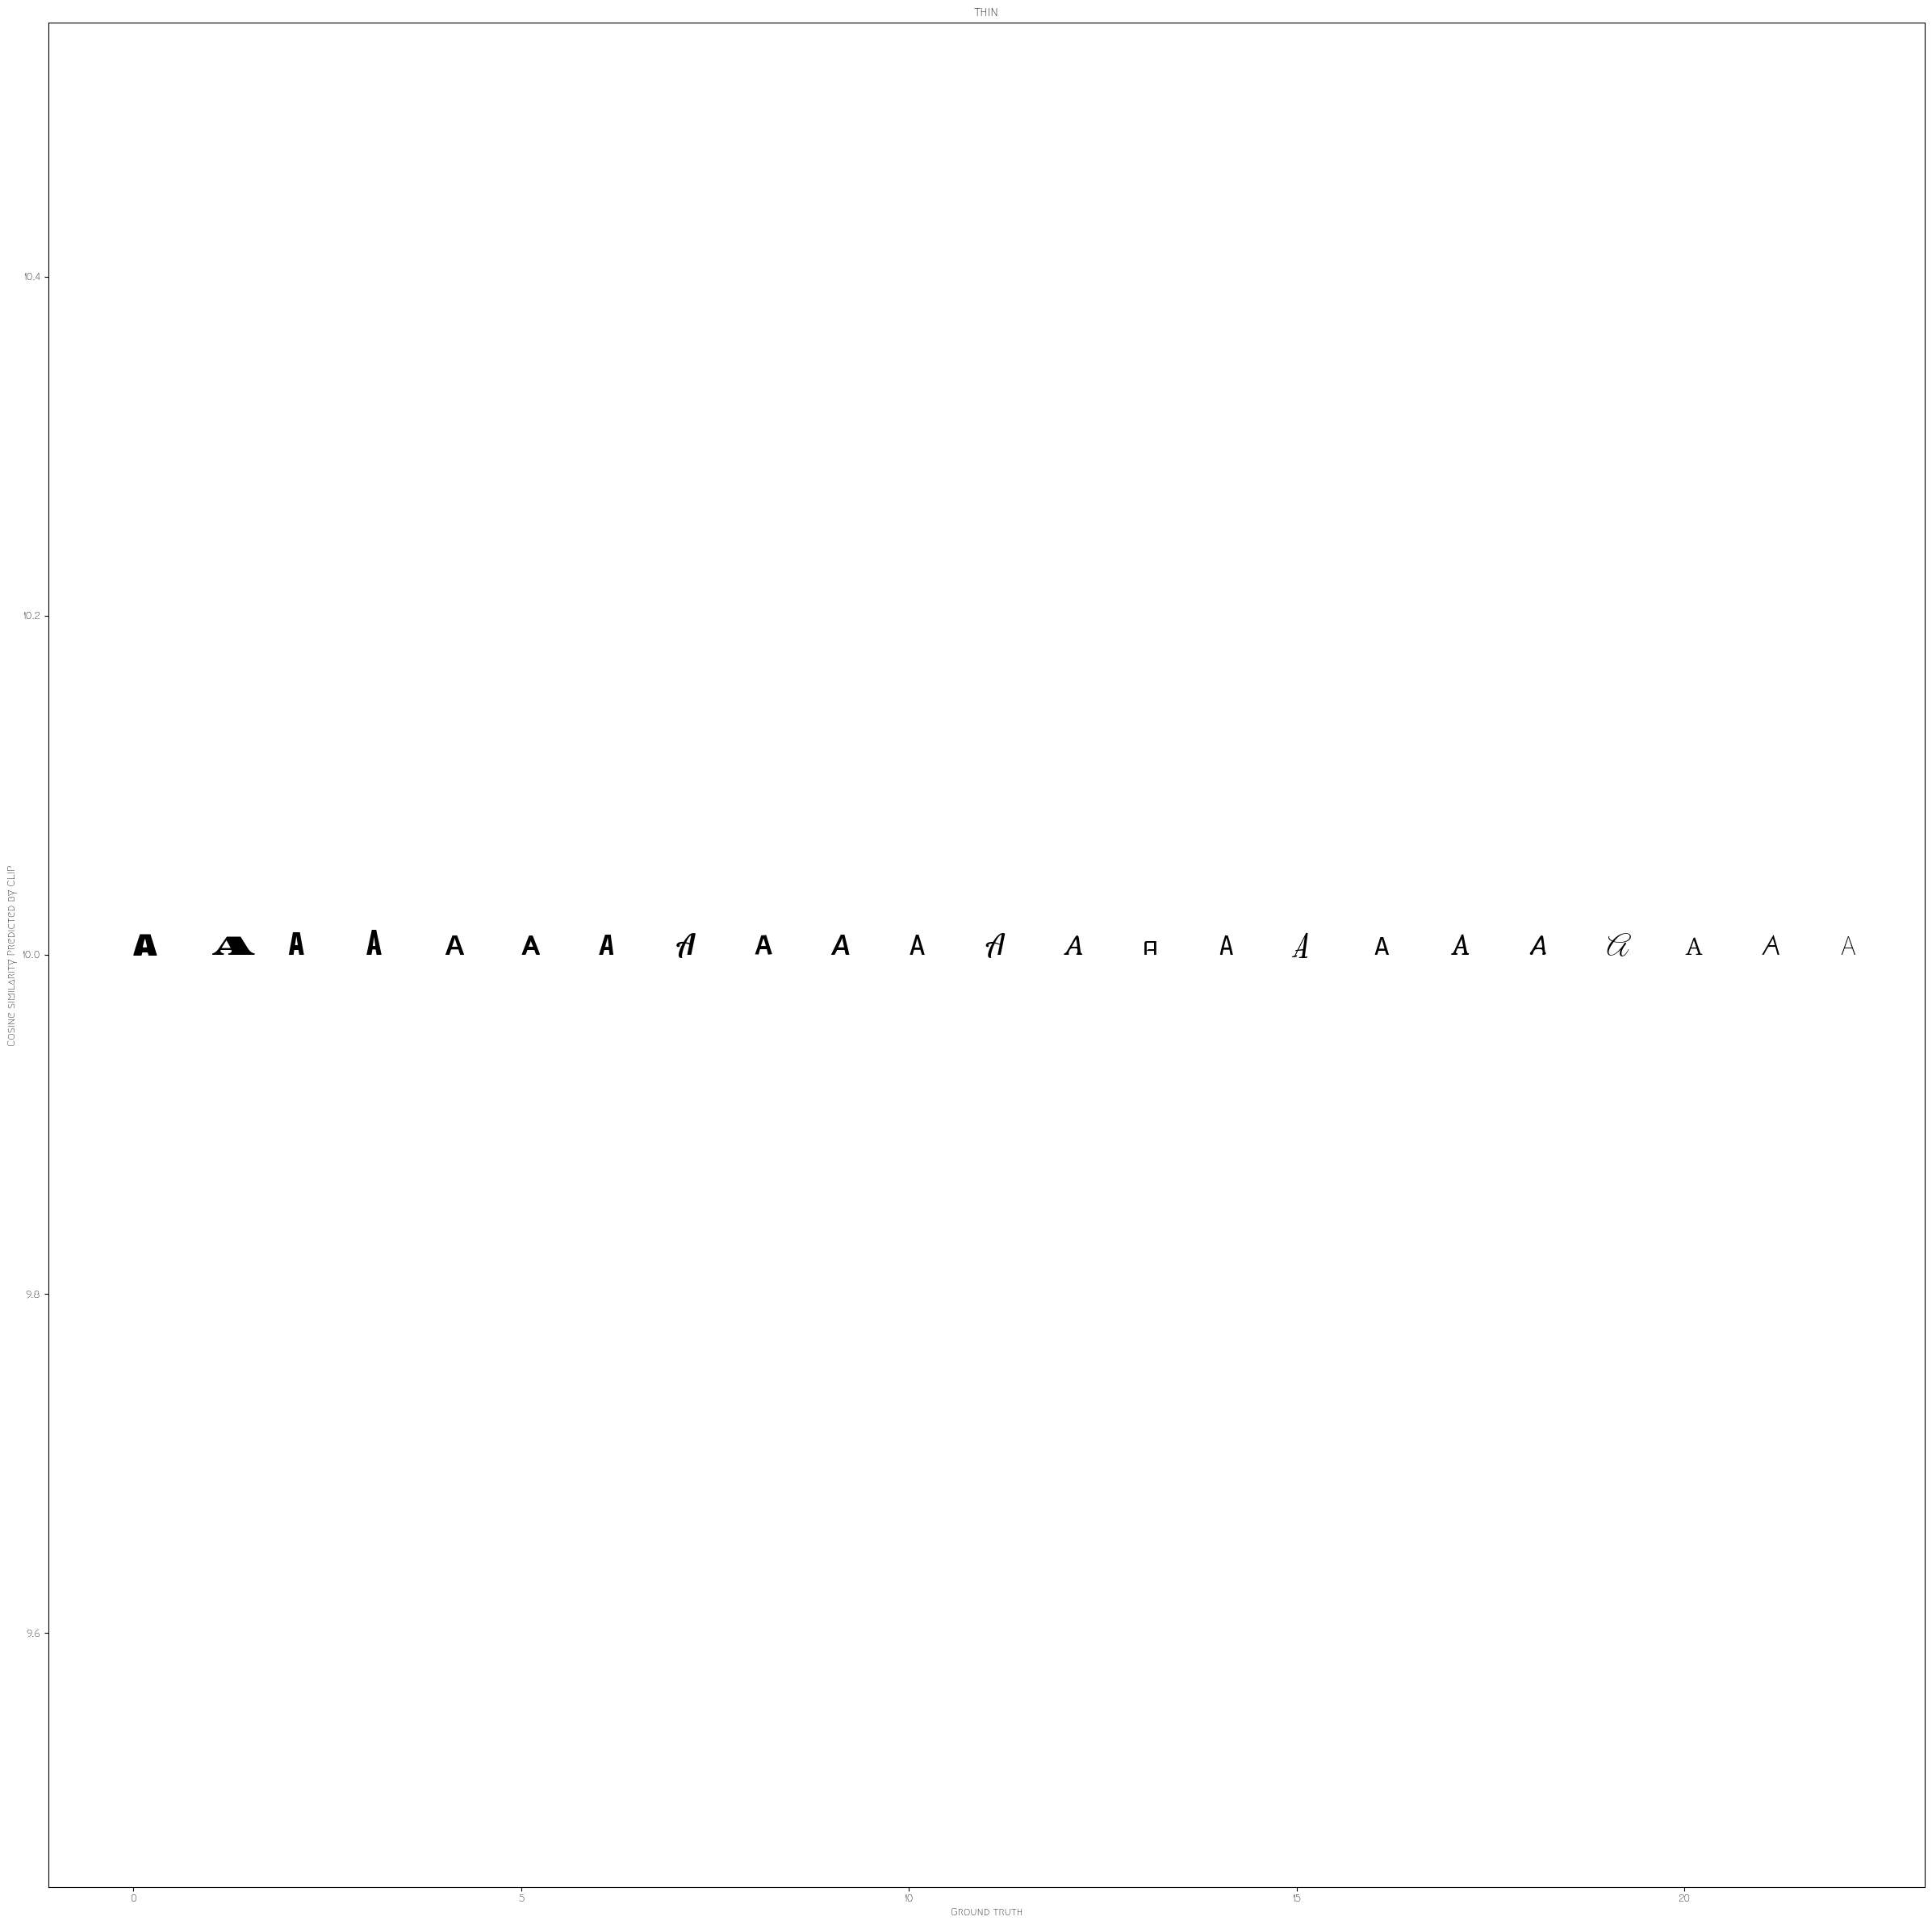

In [ ]:

text = 'A'
fig_size = (30, 30)

fig, ax = plt.subplots(figsize=fig_size)
ys = [10] * len(sorted_index)
ax.scatter(sorted_index, ys, alpha=0.0)
#ax.set_title(f'Correlation coefficient: {target_attribute}')
ax.set_title(f'{target_attribute}')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Cosine similarity Predicted by CLIP')
my_font = FontProperties()

for i, j in enumerate(sorted_index):
    font_path = font_paths[j]
    font_index = font_name_to_index[os.path.splitext(os.path.basename(font_path))[0]]
    font_base_name = os.path.basename(font_path)
    my_font.set_file(font_path)
    ax.annotate(text, (i, ys[font_index]), fontsize=25, fontproperties=my_font)

plt.savefig(f'{target_attribute}.png')
plt.show()



# Evaluate CJ Fonts

In [ ]:
from fontTools.ttLib import TTFont

def is_japanese_font(font_path):
    font = TTFont(font_path)
    japanese_ranges = [
        (0x3040, 0x309f), # Hiragana
    ]
    for table in font['cmap'].tables:
        for start, end in japanese_ranges:
            for code in range(start, end+1):
                if table.isUnicode() and table.cmap.get(code):
                    return True
    return False

No json path, use predict mode.
font_dir is list


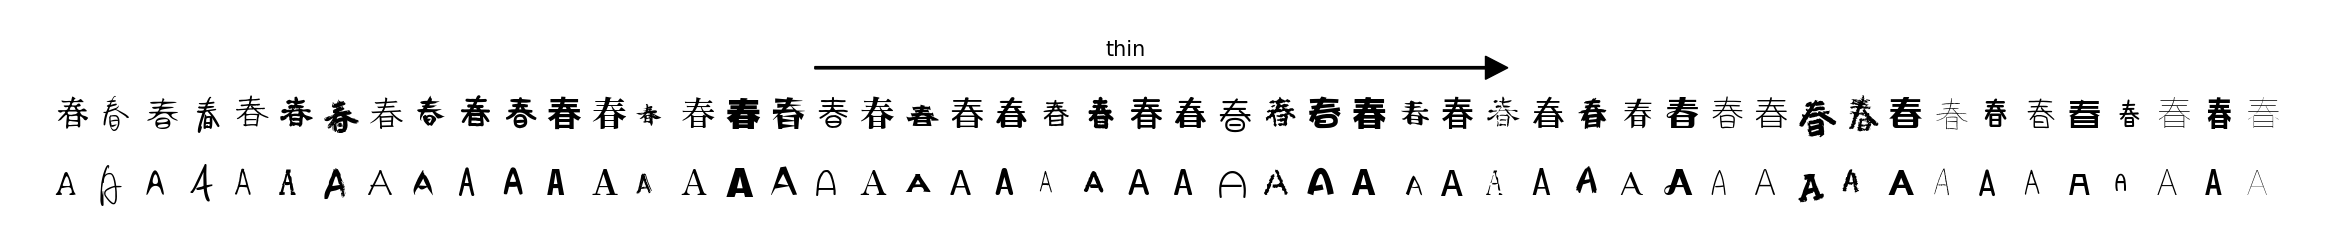

No json path, use predict mode.
font_dir is list


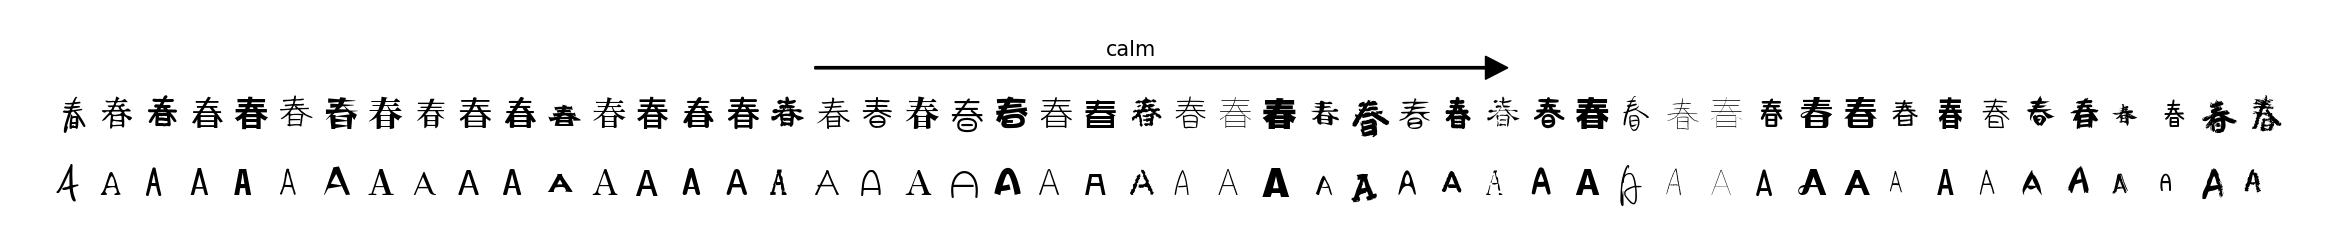

No json path, use predict mode.
font_dir is list


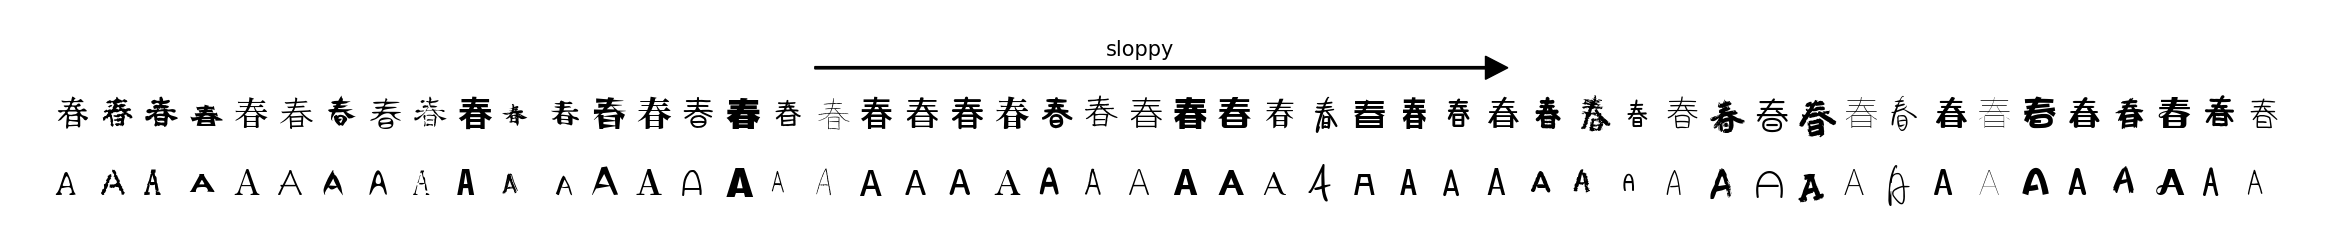

No json path, use predict mode.
font_dir is list


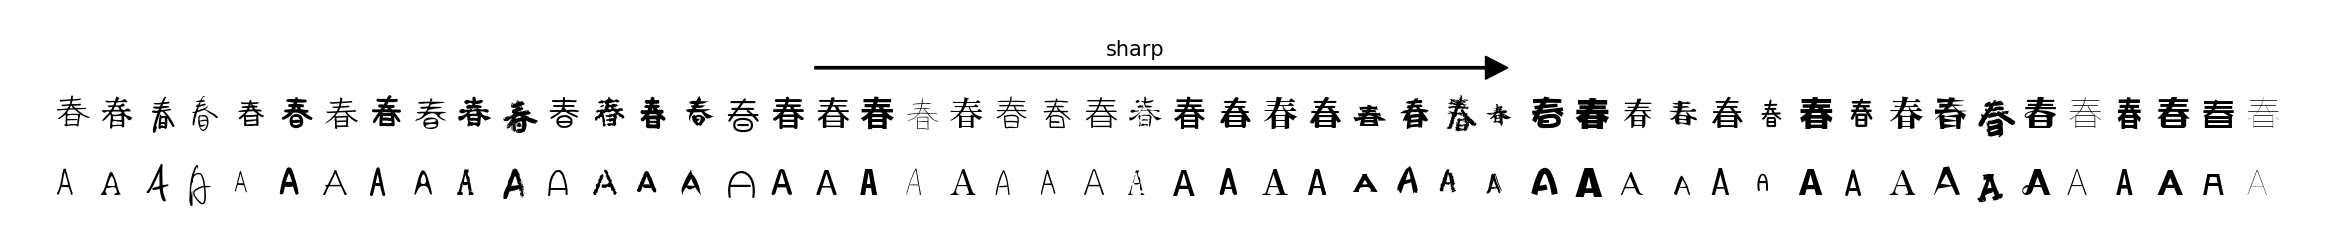

No json path, use predict mode.
font_dir is list


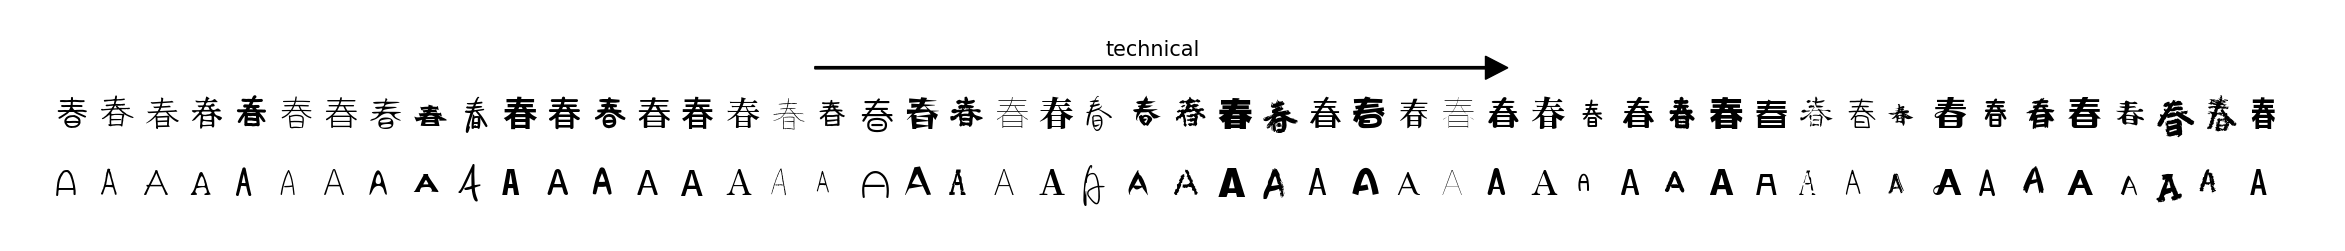

No json path, use predict mode.
font_dir is list


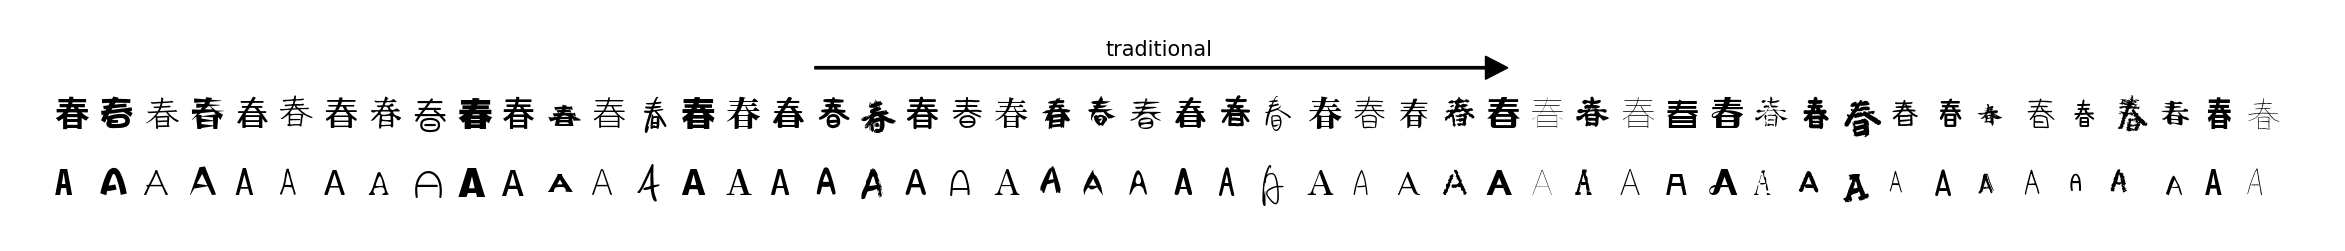

No json path, use predict mode.
font_dir is list


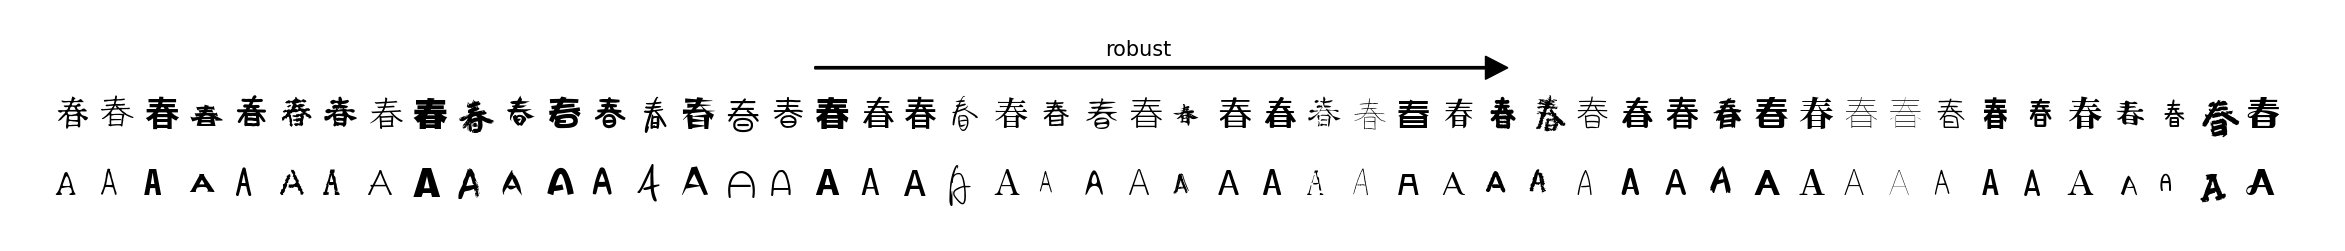

No json path, use predict mode.
font_dir is list


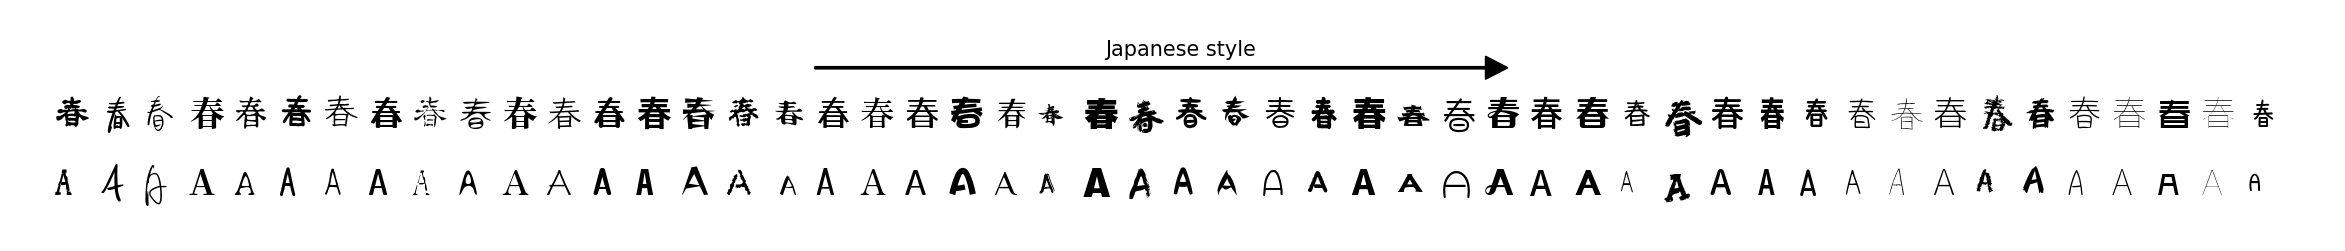

In [ ]:
cj_font_dir = '../all-fonts'
text = fox_text
text = '春夏\n秋冬'
texts_for_font_image = [text]
#texts_for_font_image = [fox_text]
#text = 'A春'
char_size = 150
line_num = text.count('\n') + 1
width = int(char_size * len(text) / line_num)
height = int((char_size+50) * line_num)
font_paths = [os.path.join(cj_font_dir, f) for f in os.listdir(cj_font_dir)]


target_attributes = ['thin', 'calm', 'sloppy', 'sharp', 'technical', 'traditional', 'robust', 'Japanese style']
checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_1011_use_weight_image_file_dir_ex.pt'
#checkpoint_path = 'model_checkpoints/67891011_891011_multiple_3_1000_image_file_dir_aug_ex.pt'

checkpoint_path = None
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
image_file_dir = None

model_type = 'clip_cj'

for target_attribute in target_attributes:

    tmp_target_attributes = [target_attribute]
    cj_data = TestDataset(fifty_font_paths, None, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=tmp_target_attributes, image_file_dir=image_file_dir, dump_image=True)
    tmp_cos_sim = calculate_corr(model, cj_data, predict_mode=True)
    sorted_index = np.argsort(tmp_cos_sim)
    cos_sim = sorted_index


    text = '春'
    #text = 'A'
    fig_size = (30, 3)

    fig, ax = plt.subplots(figsize=fig_size)
    ys = [10] * len(cos_sim)
    ax.scatter(cos_sim, ys, alpha=0.0)
    #ax.set_title(f'Correlation coefficient: {target_attribute}')
    #ax.set_title(f'{target_attribute}')
    ax.set_xlabel('Ground truth')
    ax.set_ylabel('Cosine similarity Predicted by CLIP')

    font_paths = cj_data.font_paths
    my_font = FontProperties()


    for i, j in enumerate(cos_sim):
        font_path = font_paths[j]
        font_base_name = os.path.basename(font_path)
        #mpl.rcParams['font.family'] = ttf.name
        my_font.set_file(font_path)
        ax.annotate(text, (i, ys[i]), fontsize=25, fontproperties=my_font)
        ax.annotate('A', (i, 9.97), fontsize=25, fontproperties=my_font)
        continue
    #ax.set_xlim()
    ax.set_xlim(-1, len(cos_sim)+1)
    ax.set_ylim(9.95, 10.05)
    ax.annotate(f'{target_attribute}', (23.5, 10.03), fontsize=15)
    ax.arrow(17, 10.025, 15, 0, shape='full', head_width=0.01, head_length=0.5, fc='k', ec='k')
    ax.axis('off')

    #plt.savefig(f'outputs/fclip_cj_{target_attribute}.png')
    target_attribute = target_attribute.replace(' ', '_')
    plt.savefig(f'outputs/{model_type}_{target_attribute}.png')
    plt.show()


In [ ]:

"""
model = load_model(model, checkpoint_path='model_checkpoints/best_fox_negative_91011_1011_use_weight_ex_2e5.pt', requires_grad=False)
result = {}
for font_path in cj_data.font_paths:
    font_name = os.path.splitext(os.path.basename(font_path))[0]
    result[font_name] = {}
for target_attribute in inclusive_attributes:
    target_attributes = [target_attribute]
    cj_data = TestDataset(cj_font_dir, None, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=target_attributes)
    cos_sim = calculate_corr(model, cj_data, predict_mode=True)
    assert len(cos_sim) == len(cj_data.font_paths)
    for i, font_path in enumerate(cj_data.font_paths):
        font_name = os.path.splitext(os.path.basename(font_path))[0]
        result[font_name][target_attribute] = float(cos_sim[i])
#
with open('../attributeData/predicted_cj_font_attribute.json', 'w') as f:
    json.dump(result, f)
"""

# Visualization of CLIP and FCLIP

No json path, use predict mode.
font_dir is list


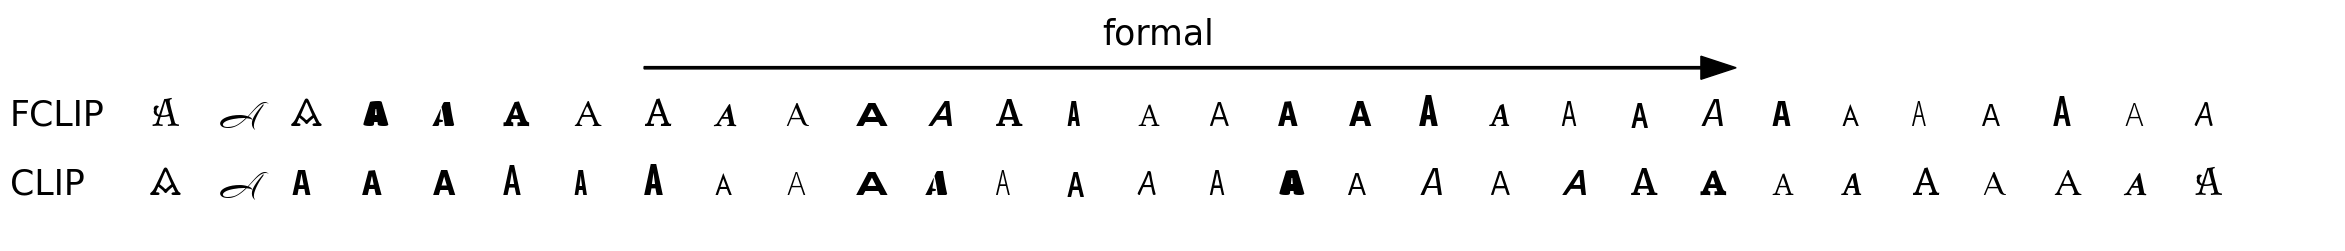

In [ ]:

font_dir = '../gwfonts'
text = fox_text
texts_for_font_image = [text]
char_size = 150
line_num = text.count('\n') + 1
width = int(char_size * len(text) / line_num)
height = int((char_size+50) * line_num)
tmp_font_paths = validation_font_paths[:30]
image_file_dir = None

model_type = 'clip_and_fclip_roman'

target_attribute = 'formal'
tmp_target_attributes = [target_attribute]
cj_data = TestDataset(tmp_font_paths, None, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=tmp_target_attributes, image_file_dir=image_file_dir, dump_image=True)

checkpoint_path = None
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
tmp_cos_sim = calculate_corr(model, cj_data, predict_mode=True)
sorted_index = np.argsort(tmp_cos_sim)
clip_cos_sim = sorted_index

checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_1011_use_weight_image_file_dir_ex.pt'
#checkpoint_path = 'model_checkpoints/91011_91011_all_ex.pt'
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
tmp_cos_sim = calculate_corr(model, cj_data, predict_mode=True)
sorted_index = np.argsort(tmp_cos_sim)
fclip_cos_sim = sorted_index

assert len(clip_cos_sim) == len(fclip_cos_sim)


text = 'A'
fig_size = (30, 3)

fig, ax = plt.subplots(figsize=fig_size)
ys = [10] * len(clip_cos_sim)
ax.scatter(clip_cos_sim, ys, alpha=0.0)
#ax.set_title(f'Correlation coefficient: {target_attribute}')
#ax.set_title(f'{target_attribute}')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Cosine similarity Predicted by CLIP')

my_font = FontProperties()


for i in range(len(clip_cos_sim)):
    clip_font_path = tmp_font_paths[clip_cos_sim[i]]
    fclip_font_path = tmp_font_paths[fclip_cos_sim[i]]

    font_base_name = os.path.basename(clip_font_path)
    my_font.set_file(clip_font_path)
    ax.annotate(text, (i, 9.97), fontsize=25, fontproperties=my_font)

    font_base_name = os.path.basename(fclip_font_path)
    my_font.set_file(clip_font_path)
    my_font.set_file(fclip_font_path)
    ax.annotate(text, (i, 10), fontsize=25, fontproperties=my_font)
    continue


#ax.set_xlim()
ax.set_xlim(-2, len(clip_cos_sim)+1)
ax.set_ylim(9.95, 10.05)
ax.annotate('FCLIP', (-2, 10), fontsize=25)
ax.annotate('CLIP', (-2, 9.97), fontsize=25)
ax.annotate(f'{target_attribute}', (13.5, 10.035), fontsize=25)
ax.arrow(7, 10.025, 15, 0, shape='full', head_width=0.01, head_length=0.5, fc='k', ec='k')
ax.axis('off')

#plt.savefig(f'outputs/fclip_cj_{target_attribute}.png')
target_attribute = target_attribute.replace(' ', '_')
plt.savefig(f'outputs/{model_type}_{target_attribute}.png')
plt.show()


# SVG

In [ ]:
from fontTools.ttLib import TTFont
from fontTools.pens.svgPathPen import SVGPathPen
from svgwrite import Drawing
from svgpathtools import svg2paths, wsvg
from IPython.display import SVG, display

In [ ]:
def create_svg_from_font(font_paths, character, target_attribute, output_path=None, char_size=200, size=None, base_font_path = '../gwfonts/ABeeZee-Regular.ttf'):

    if size is None:
        size = char_size * len(font_paths)

    dwg = Drawing(output_path, profile='tiny', size=(size, char_size * 4))
    for i, font_path in enumerate(font_paths):
        font = TTFont(font_path)
        glyph_set = font.getGlyphSet()
        glyph = glyph_set[character]
        scale = char_size / font['head'].unitsPerEm

        pen = SVGPathPen(glyph_set)
        glyph.draw(pen)

        # transform and scale
        #g = dwg.g(transform=f'scale({scale}) translate(0, { char_size })')
        x_offset = i * char_size
        y_offset = 80
        g = dwg.g(transform=f'translate({x_offset}, {char_size + y_offset}) scale({scale}, -{scale})')
        path = dwg.path(pen.getCommands(), fill='black')
        g.add(path)
        dwg.add(g)
    
    x_center = size / 2
    y_attribute = 0
    font = TTFont(base_font_path)
    glyph_set = font.getGlyphSet()
    attribute_char_size = char_size / 4

    m = len(target_attribute) // 2

    for i, character in enumerate(target_attribute):
        glyph = glyph_set[character]
        pen = SVGPathPen(glyph_set)
        glyph.draw(pen)
        scale = attribute_char_size / font['head'].unitsPerEm
        g = dwg.g(transform=f'translate({x_center + attribute_char_size / 1 * (i - m)}, {attribute_char_size + y_attribute + 10}) scale({scale}, -{scale})')
        path = dwg.path(pen.getCommands(), fill='black')
        g.add(path)
        dwg.add(g)
    
    # draw line
    line_x1 = 0
    line_x2 = size - 20
    line_y = attribute_char_size + y_attribute + 40
    dwg.add(dwg.line((line_x1, line_y), (line_x2, line_y), stroke='black', stroke_width=5))

    # draw triangle
    triangle_size = 20
    triangle_y1 = line_y - triangle_size
    triangle_y2 = line_y + triangle_size
    triangle_y3 = line_y
    triangle_x1 = line_x2 - triangle_size
    triangle_x2 = line_x2 - triangle_size
    triangle_x3 = line_x2 + triangle_size
    dwg.add(dwg.polygon([(triangle_x1, triangle_y1), (triangle_x2, triangle_y2), (triangle_x3, triangle_y3)], fill='black'))


    dwg.save()
    return output_path


In [ ]:

def create_svg_from_font_two_lines(font_paths, clip_cos_sim, fclip_cos_sim, character, target_attribute, output_path=None, char_size=200, size=None, base_font_path = '../gwfonts/ABeeZee-Regular.ttf', target_font_paths=None):
    if target_font_paths is None:
        target_font_paths = font_paths

    x_offset_adjust = 20
    x_start = char_size * 4
    if size is None:
        size = x_start + (char_size + x_offset_adjust) * (len(target_font_paths) + 2)

    dwg = Drawing(output_path, profile='tiny', size=(size, char_size * 5))
    x_offset_clip = x_start
    x_offset_fclip = x_start
    for i in range(len(font_paths)):
        #x_offset = x_start + i * (char_size +  x_offset_adjust)
        y_offset = 80
        font_path = font_paths[clip_cos_sim[i]]
        if font_path in target_font_paths:
            x_offset_clip += char_size + x_offset_adjust
            font = TTFont(font_path)
            glyph_set = font.getGlyphSet()
            glyph = glyph_set[character]
            scale = char_size / font['head'].unitsPerEm

            pen = SVGPathPen(glyph_set)
            glyph.draw(pen)

            # transform and scale
            #g = dwg.g(transform=f'scale({scale}) translate(0, { char_size })')
            g = dwg.g(transform=f'translate({x_offset_clip}, {char_size + y_offset}) scale({scale}, -{scale})')
            path = dwg.path(pen.getCommands(), fill='black')
            g.add(path)
            dwg.add(g)

        font_path = font_paths[fclip_cos_sim[i]]
        if font_path in target_font_paths:
            x_offset_fclip += char_size + x_offset_adjust
            font = TTFont(font_path)
            glyph_set = font.getGlyphSet()
            glyph = glyph_set[character]
            scale = char_size / font['head'].unitsPerEm

            pen = SVGPathPen(glyph_set)
            glyph.draw(pen)

            # transform and scale
            #g = dwg.g(transform=f'scale({scale}) translate(0, { char_size })')
            g = dwg.g(transform=f'translate({x_offset_fclip}, {char_size + y_offset + char_size + char_size // 2}) scale({scale}, -{scale})')
            path = dwg.path(pen.getCommands(), fill='black')
            g.add(path)
            dwg.add(g)
    
    x_center = x_start + (size - x_start) / 2
    y_attribute = 0
    font = TTFont(base_font_path)
    glyph_set = font.getGlyphSet()
    attribute_char_size = char_size / 1.5

    m = len(target_attribute) // 2

    for i, character in enumerate(target_attribute):
        glyph = glyph_set[character]
        pen = SVGPathPen(glyph_set)
        glyph.draw(pen)
        scale = attribute_char_size / font['head'].unitsPerEm
        g = dwg.g(transform=f'translate({x_center + attribute_char_size / 1 * (i - m)}, {attribute_char_size + y_attribute + 10}) scale({scale}, -{scale})')
        path = dwg.path(pen.getCommands(), fill='black')
        g.add(path)
        dwg.add(g)
    
    x_text = 0
    text = 'CLIP'
    for i, character in enumerate(text):
        glyph = glyph_set[character]
        pen = SVGPathPen(glyph_set)
        glyph.draw(pen)
        scale = char_size / font['head'].unitsPerEm
        tmp_x_offset = 20
        if character == 'P':
            tmp_x_offset = 25
        g = dwg.g(transform=f'translate({x_text + (char_size - tmp_x_offset) * i}, {char_size + y_offset}) scale({scale}, -{scale})')
        path = dwg.path(pen.getCommands(), fill='black')
        g.add(path)
        dwg.add(g)

    text = 'FCLIP'
    for i, character in enumerate(text):
        glyph = glyph_set[character]
        pen = SVGPathPen(glyph_set)
        glyph.draw(pen)
        scale = char_size / font['head'].unitsPerEm
        tmp_x_offset = 20
        if character == 'P':
            tmp_x_offset = 23.5
        g = dwg.g(transform=f'translate({x_text + (char_size - tmp_x_offset) * i}, {char_size + y_offset + char_size + char_size // 2}) scale({scale}, -{scale})')
        path = dwg.path(pen.getCommands(), fill='black')
        g.add(path)
        dwg.add(g)
    
    # draw line
    stroke_width = 5
    line_x1 = x_start
    line_x2 = size - 19
    line_y = attribute_char_size + y_attribute + 40
    dwg.add(dwg.line((line_x1, line_y), (line_x2, line_y), stroke='black', stroke_width=stroke_width))

    # draw triangle
    triangle_size = 10
    triangle_y1 = line_y - triangle_size
    triangle_y2 = line_y + triangle_size
    #triangle_y2 = line_y
    triangle_y3 = line_y
    triangle_x1 = line_x2 - triangle_size
    triangle_x2 = line_x2 - triangle_size
    triangle_x3 = line_x2 + triangle_size
    dwg.add(dwg.polygon([(triangle_x1, triangle_y1), (triangle_x2, triangle_y2), (triangle_x3, triangle_y3)], fill='black'))


    dwg.save()
    return output_path

In [ ]:
dramatic_font_paths = None

No json path, use predict mode.
font_dir is list


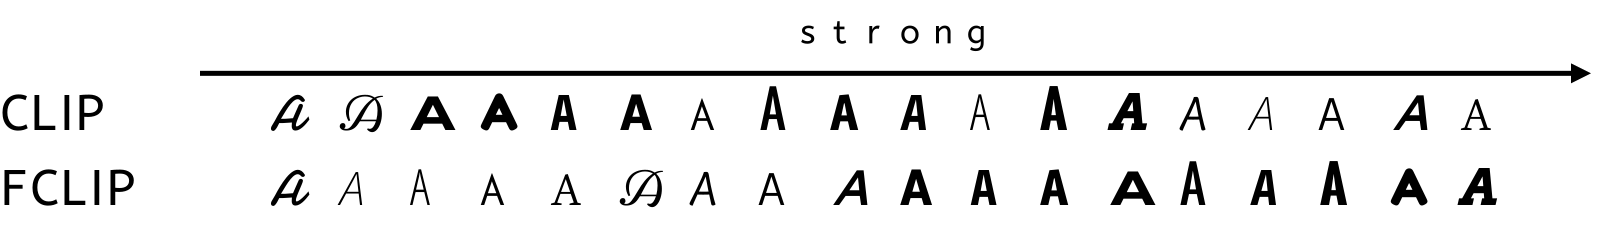

In [ ]:
font_dir = '../gwfonts'
fox_text = 'The quick\nbrown fox\njumps over\nthe lazy dog'
fox_text = 'A'
text = fox_text
texts_for_font_image = [text]
char_size = 150
line_num = text.count('\n') + 1
width = int(char_size * len(text) / line_num)
height = int((char_size+50) * line_num)
tmp_font_paths = validation_font_paths[:50]
image_file_dir = None

model_type = 'clip_and_fclip_roman'

target_attribute = 'strong'
tmp_target_attributes = [target_attribute]
cj_data = TestDataset(tmp_font_paths, None, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=tmp_target_attributes, image_file_dir=image_file_dir, dump_image=True)

checkpoint_path = None
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
tmp_cos_sim = calculate_corr(model, cj_data, predict_mode=True)
sorted_index = np.argsort(tmp_cos_sim)
clip_cos_sim = sorted_index

checkpoint_path = 'model_checkpoints/new_best_fox_negative_91011_1011_use_weight_image_file_dir_ex.pt'
#checkpoint_path = 'model_checkpoints/91011_91011_all_ex.pt'
model = load_model(model, checkpoint_path=checkpoint_path, requires_grad=False)
tmp_cos_sim = calculate_corr(model, cj_data, predict_mode=True)
sorted_index = np.argsort(tmp_cos_sim)
fclip_cos_sim = sorted_index

assert len(clip_cos_sim) == len(fclip_cos_sim)


output_path = 'outputs/svg/test.svg'
display(SVG(create_svg_from_font_two_lines(tmp_font_paths, clip_cos_sim, fclip_cos_sim, 'A', target_attribute, output_path=output_path, char_size=50, target_font_paths=dramatic_font_paths)))

In [ ]:
dramatic_font_paths = [validation_font_paths[i] for i in fclip_cos_sim[:8]] + [validation_font_paths[i] for i in fclip_cos_sim[-10:]]

# prepare SVG Image

## show non-augmented image

In [1]:
text = 'the quick\nbrown fox\njumps over\nthe lazy dog'
text = 'Hello World!'
text = 'Eurographics'
#text = 'WOOD'
#text = 'SIGGRAPH\nASIA'
#text = '安全出行'
#text = 'シーグラフ\nアジア'

font_path = '../gwfonts/PTSerif-BoldItalic.ttf'
font_path = '../all-fonts/HarmonyOS_Sans_SC_Black.ttf'
font_path = '../all-fonts/ZenOldMincho-Regular.ttf'
font_path = '../all-fonts/ipaexg.ttf'
font_path = '../gwfonts/SourceCodePro-ExtraLight.ttf'
font_path = '../gwfonts/Frijole.ttf'
font_path = '../gwfonts/Orbitron-Black.ttf'
font_path = '../gwfonts/MavenPro-Black.ttf'
font_path = '../gwfonts/EagleLake-Regular.ttf'
font_path = '../gwfonts/BadScript-Regular.ttf'
font_path = '../gwfonts/Slackey.ttf'
font_path = '../gwfonts/Sedan-Italic.ttf'
font_path = '../gwfonts/Arimo-BoldItalic.ttf'
font_path = '../gwfonts/OriginalSurfer-Regular.ttf'
font_path = '../gwfonts/Paprika-Regular.ttf'
font_path = '../gwfonts/Roboto-MediumItalic.ttf'
font_path = '../gwfonts/Cabin-SemiBoldItalic.ttf'
font_path = '../gwfonts/Julee-Regular.ttf'
font_path = '../gwfonts/Sevillana-Regular.ttf'
font_path = '../gwfonts/Astloch-Bold.ttf'
font_path = '../gwfonts/FingerPaint.ttf'
font_path = '../gwfonts/Lobster.ttf'
font_path = '../gwfonts/Alegreya-BoldItalic.ttf'
font_path = '../gwfonts/PTSerif-BoldItalic.ttf'
font_path = '../gwfonts/Lora-BoldItalic.ttf'
font_path = '../gwfonts/Magra-Bold.ttf'
font_path = '../gwfonts/Muli.ttf'

font_name = os.path.splitext(os.path.basename(font_path))[0]
my_font = FontProperties(fname=font_path)

fig, ax = plt.subplots()

ax.text(0.5, 0.5, text, ha='center', va='center', size=50, font_properties=my_font)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

axis_off = True
if axis_off:
    ax.axis('off')


if axis_off:
    fig.savefig(f'outputs/svg/{font_name}_no_boundary.svg')
else:
    fig.savefig(f'outputs/svg/{font_name}.svg')
plt.show()

NameError: name 'os' is not defined

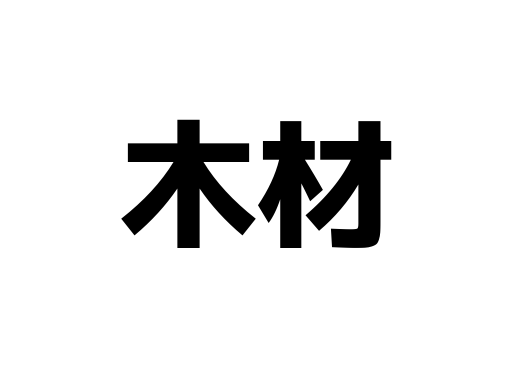

In [ ]:
text = 'the quick\nbrown fox\njumps over\nthe lazy dog'
text = 'SIGGRAPH\nASIA'
text = '安全出行'
text = '安全出行\n春夏秋冬'
text = '春夏\n秋冬'
text = '木材'
#text = 'シーグラフ\nアジア'
#text = 'Sushi.\nStill your best bet\nfor intestinal worms.'


font_path = '../all-fonts/Tanugo-TTF-ExtraLight.ttf'
font_path = '../all-fonts/851CHIKARA-DZUYOKU_kanaA_004.ttf'
font_path = '../all-fonts/HarmonyOS_Sans_SC_Black.ttf'
font_path = '../all-fonts/ipaexg.ttf'
font_path = '../all-fonts/Kazesawa-Extrabold.ttf'
font_path = '../all-fonts/HarmonyOS_Sans_SC_Thin.ttf'
font_path = '../all-fonts/MavenProBlack.otf'
font_path = '../all-fonts/mqinghuahk.otf'
font_path = '../all-fonts/851MkPOP_101.ttf'
font_path = '../all-fonts/ZenjidoJP-FeltPenLMT-TTF.ttf'
font_path = '../all-fonts/M+A1_heavy-50-1.2.otf'
font_path = '../all-fonts/myoungheihk.ttf'
font_path = '../all-fonts/Mamelon-4-Hi-Regular.otf'
font_path = '../all-fonts/KiwiMaru-Light.ttf'
font_path = '../all-fonts/Mamelon-3-Hi-Regular.otf'
font_path = '../all-fonts/Hosohuwafont.ttf'
font_path = '../all-fonts/ZenMaruGothic-Medium.ttf'
#font_path = '../all-fonts/gomarice_mukasi_mukasi.ttf'
#font_path = '../all-fonts/myoungheihks.ttf'
font_path = '../all-fonts/uzura.ttf'
font_path = '../all-fonts/SentyCaramel.ttf'
font_path = '../all-fonts/HanyiSentyLotus.ttf'
font_path = '../all-fonts/JP_Ronde-B_square.otf'
#font_path = '../all-fonts/HannariMincho-Regular.otf'
#font_path = '../all-fonts/komorebi-gothic.ttf'
#font_path = '../all-fonts/幻ノにじみ明朝.otf'
#font_path = '../all-fonts/ipaexm.ttf'
font_path = '../all-fonts/Tanugo-TTF-Regular.ttf'
font_path = '../all-fonts/ZCOOLXiaoWei-Regular.ttf'
font_path = '../all-fonts/かんじゅくゴシック.otf'
font_path = '../all-fonts/SentyTamarind.ttf'
font_path = '../all-fonts/LXGWWenKai-Bold.ttf'
font_path = '../all-fonts/SourceHanSerif-Heavy.otf'
font_path = '../all-fonts/YuseiMagic-Regular.ttf'
font_path = '../all-fonts/NotoSansJP-Black.otf'
font_path = '../all-fonts/Murecho-Regular.ttf'
font_path = '../all-fonts/HarmonyOS_Sans_SC_Bold.ttf'
font_path = '../all-fonts/Kazesawa-ExtraBold.ttf'
font_path = '../all-fonts/Kazesawa-Extrabold.ttf'


font_name = os.path.splitext(os.path.basename(font_path))[0]
my_font = FontProperties(fname=font_path)

fig, ax = plt.subplots()

ax.text(0.5, 0.5, text, ha='center', va='center', size=100, font_properties=my_font)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

axis_off = True
if axis_off:
    ax.axis('off')


if axis_off:
    fig.savefig(f'outputs/svg/{font_name}_no_boundary.svg')
    fig.savefig(f'outputs/svg/{font_name}.png')
else:
    fig.savefig(f'outputs/svg/{font_name}.svg')
    fig.savefig(f'outputs/svg/{font_name}.png')
plt.show()

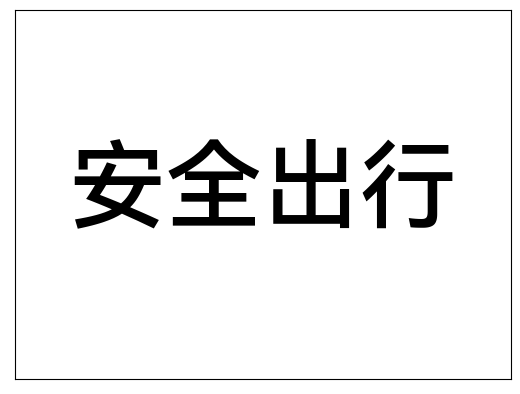

In [ ]:
text = 'the quick\nbrown fox\njumps over\nthe lazy dog'
text = 'SIGGRAPH\nASIA'
text = '安全出行'


font_path = '../all-fonts/HanyiSentyPomelo.ttf'
font_path = '../all-fonts/HanyiSentyJournal.ttf'
font_path = '../all-fonts/HanyiSentyLotus.ttf'
font_path = '../all-fonts/DroidSansFallback.ttf'
font_path = '../all-fonts/AsobiMemogaki-Regular-1-01.ttf'

font_path = '../all-fonts/HanyiSentyPomelo.ttf'
font_path = '../all-fonts/HanyiSentyJournal.ttf'
font_path = '../all-fonts/DroidSansFallback.ttf'
font_path = '../all-fonts/AsobiMemogaki-Regular-1-01.ttf'
font_path = '../all-fonts/HarmonyOS_Sans_SC_Medium.ttf'


font_name = os.path.splitext(os.path.basename(font_path))[0]
my_font = FontProperties(fname=font_path)

fig, ax = plt.subplots()

ax.text(0.5, 0.5, text, ha='center', va='center', size=70, font_properties=my_font)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

axis_off = False
if axis_off:
    ax.axis('off')


if axis_off:
    fig.savefig(f'outputs/svg/{font_name}_no_boundary.svg')
else:
    fig.savefig(f'outputs/svg/{font_name}.svg')
plt.show()

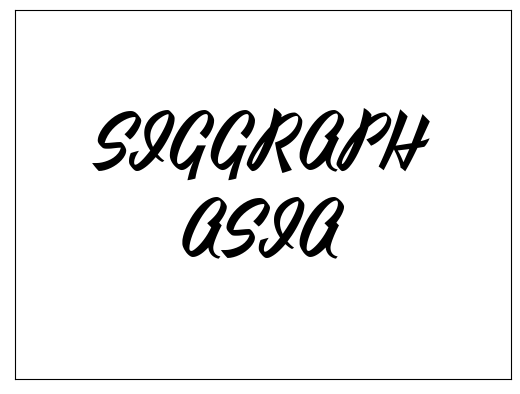

In [ ]:
text = 'the quick\nbrown fox\njumps over\nthe lazy dog'
text = 'SIGGRAPH\nASIA'

#font_path = '../gwfonts/MervaleScript-Regular.ttf'
#font_path = '../gwfonts/Sedan-Italic.ttf'
#font_path = '../gwfonts/YanoneTagesschrift.ttf'
#font_path = '../gwfonts/Satisfy.ttf'
#font_path = '../gwfonts/BadScript-Regular.ttf'

font_path = '../gwfonts/IMFeENit28P.ttf'
#font_path = '../gwfonts/Miama-Regular.ttf'
#font_path = '../gwfonts/MervaleScript-Regular.ttf'
#font_path = '../gwfonts/Pacifico.ttf'
#font_path = '../gwfonts/Sedan-Italic.ttf'

font_path = '../gwfonts/Bonbon-Regular.ttf'
font_path = '../gwfonts/PetitFormalScript-Regular.ttf'
font_path = '../gwfonts/Sevillana-Regular.ttf'
font_path = '../gwfonts/MeieScript-Regular.ttf'
font_path = '../gwfonts/Parisienne-Regular.ttf'

font_path = '../gwfonts/Sevillana-Regular.ttf'
font_path = '../gwfonts/PetitFormalScript-Regular.ttf'
font_path = '../gwfonts/Bonbon-Regular.ttf'
font_path = '../gwfonts/Yesteryear-Regular.ttf'
#font_path = '../gwfonts/Parisienne-Regular.ttf'


font_name = os.path.splitext(os.path.basename(font_path))[0]
my_font = FontProperties(fname=font_path)

fig, ax = plt.subplots()

ax.text(0.5, 0.5, text, ha='center', va='center', size=50, font_properties=my_font)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

axis_off = False
if axis_off:
    ax.axis('off')


if axis_off:
    fig.savefig(f'outputs/svg/{font_name}_no_boundary.svg')
else:
    fig.savefig(f'outputs/svg/{font_name}.svg')
plt.show()

## rotation

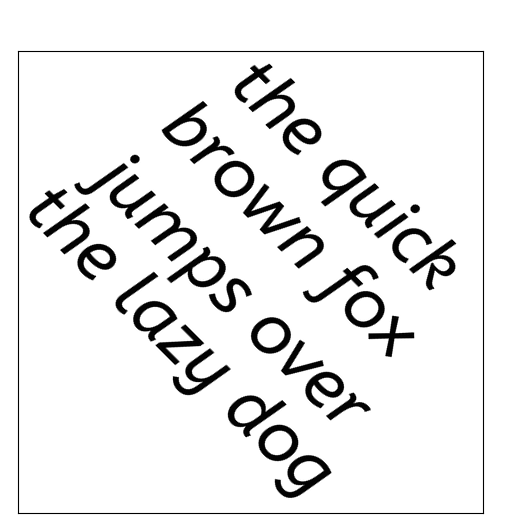

In [ ]:
text = 'the quick\nbrown fox\njumps over\nthe lazy dog'
font_path = '../gwfonts/ABeeZee-Italic.ttf'
#font_path = '../gwfonts/PassionOne-Black.ttf'

font_name = os.path.splitext(os.path.basename(font_path))[0]
my_font = FontProperties(fname=font_path)

fig, ax = plt.subplots(figsize=(6, 6))

#ax.text(0.5, 0.5, text, ha='center', va='center', size=50, font_properties=my_font, rotation=45)
rotation = 315
ax.text(0.52, 0.55, text, ha='center', va='center', size=50, font_properties=my_font, rotation=rotation)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.savefig(f'outputs/svg/{font_name}_rotation_{rotation}.svg')

## scale

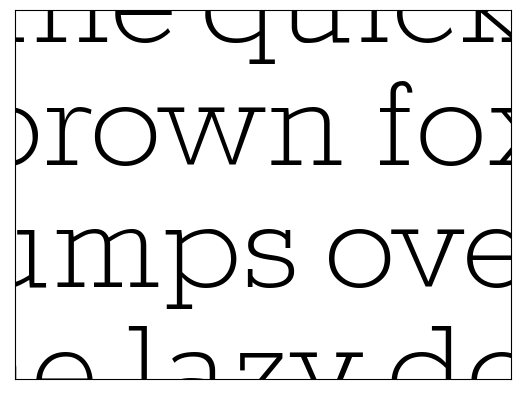

In [ ]:
text = 'the quick\nbrown fox\njumps over\nthe lazy dog'
font_path = '../gwfonts/Rokkitt-Light.ttf'
#font_path = '../gwfonts/Share-BoldItalic.ttf'
font_name = os.path.splitext(os.path.basename(font_path))[0]
my_font = FontProperties(fname=font_path)

fig, ax = plt.subplots()
size = 50
scale = 2

ax.text(0.5, 0.5, text, ha='center', va='center', size=size*scale, font_properties=my_font, clip_on=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


fig.savefig(f'outputs/svg/{font_name}_scale_{scale}.svg')
plt.show()

## all

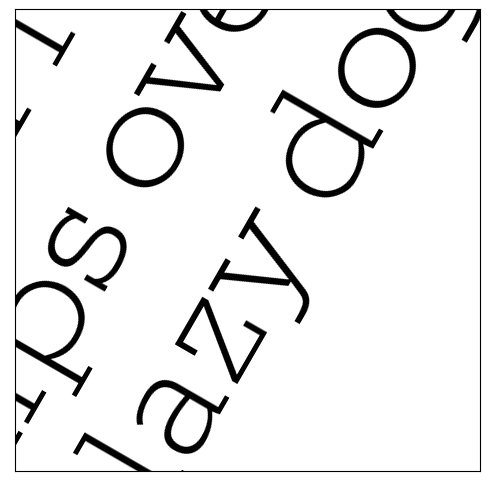

In [ ]:

text = 'the quick\nbrown fox\njumps over\nthe lazy dog'
font_path = '../gwfonts/Rokkitt-Light.ttf'
#font_path = '../gwfonts/Share-BoldItalic.ttf'

font_name = os.path.splitext(os.path.basename(font_path))[0]
my_font = FontProperties(fname=font_path)

fig, ax = plt.subplots(figsize=(6, 6))

#ax.text(0.5, 0.5, text, ha='center', va='center', size=50, font_properties=my_font, rotation=45)
rotation = 60
ax.text(0.0, 0.55, text, ha='center', va='center', size=130, font_properties=my_font, rotation=rotation, clip_on=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.savefig(f'outputs/svg/{font_name}_augmentation_2.svg')

In [ ]:
inclusive_attributes

['angular',
 'artistic',
 'attention-grabbing',
 'attractive',
 'bad',
 'boring',
 'calm',
 'charming',
 'clumsy',
 'complex',
 'delicate',
 'disorderly',
 'dramatic',
 'formal',
 'fresh',
 'friendly',
 'gentle',
 'graceful',
 'happy',
 'legible',
 'modern',
 'playful',
 'pretentious',
 'sharp',
 'sloppy',
 'soft',
 'strong',
 'technical',
 'thin',
 'warm',
 'wide']

In [ ]:
sorted(list(all_json.keys()))

['ARSMaquetteWebOne',
 'Acme-Regular',
 'AdventPro-SemiBold',
 'Aldrich',
 'Alegreya-BoldItalic',
 'AllertaStencil-Regular',
 'Amethysta-Regular',
 'Andada-Bold',
 'Andada-Italic',
 'AndadaSC-Bold',
 'AnonymousPro',
 'ArchivoNarrow-Regular',
 'ArialRoundedMTBold',
 'ArialUnicodeMS',
 'Arimo-Bold',
 'Arimo-BoldItalic',
 'Arizonia-Regular',
 'Arvo-Bold',
 'Arvo-BoldItalic',
 'Arvo-Italic',
 'Asap-Regular',
 'Asset',
 'Astloch-Bold',
 'AveriaLibre-LightItalic',
 'AveriaSansLibre-Italic',
 'AveriaSerifLibre-Italic',
 'BadScript-Regular',
 'Bello-Pro',
 'BenchNine-Regular',
 'Bentham-Regular',
 'Bevan',
 'BilboSwashCaps-Regular',
 'BlackOpsOne-Regular',
 'BowlbyOneSC-Regular',
 'Brevia-Regular',
 'BubblerOne',
 'Buenard-Bold',
 'Cabin-SemiBoldItalic',
 'CabinCondensed',
 'CabinCondensed-Medium',
 'Calluna-Regular',
 'Cantarell-BoldOblique',
 'CantoraOne-Regular',
 'Cardo-Italic',
 'CenturyGothic',
 'Chivo-Italic',
 'ClickerScript-Regular',
 'CrimsonText-BoldItalic',
 'CrimsonText-Semibold',

In [ ]:
sorted_attributes = {a: v for a, v in sorted(all_json['FingerPJaint'].items(), key=lambda x: - float(x[1]))}
sorted_attributes

{'legible': '97.81',
 'fresh': '94.09',
 'gentle': '86.36',
 'formal': '81.34',
 'friendly': '75.07',
 'strong': '73.52',
 'warm': '72.27',
 'calm': '70.3',
 'graceful': '65.53',
 'attractive': '64.77',
 'charming': '61.67',
 'soft': '60.35',
 'attention-grabbing': '60.1',
 'wide': '58.04',
 'sharp': '54.26',
 'boring': '50.94',
 'pretentious': '46.79',
 'happy': '41.57',
 'modern': '35.23',
 'dramatic': '28.64',
 'delicate': '28.35',
 'thin': '27.24',
 'technical': '25.11',
 'angular': '24.37',
 'complex': '18.56',
 'playful': '17.69',
 'bad': '17.04',
 'disorderly': '16.86',
 'clumsy': '16',
 'artistic': '13.31',
 'sloppy': '11.46',
 'serif': '9.63',
 'italic': '9.34',
 'display': '6.76',
 'cursive': '4.3',
 'capitals': '0',
 'monospace': '0'}

In [ ]:
target_attribute = 'sharp'
sorted_attributes = {a: v[target_attribute] for a, v in sorted(all_json.items(), key=lambda x:  - float(x[1][target_attribute]))}

In [ ]:
sorted_attributes

{'Cardo-Italic': '100',
 'PTSerif-BoldItalic': '99.92',
 'Amethysta-Regular': '96.53',
 'HoeflerText-Regular': '94.86',
 'KellySlab-Regular': '93.57',
 'Arvo-Italic': '92.56',
 'GFSDidot-Regular': '92.35',
 'Rosarivo-Italic': '91.64',
 'Palatino-Roman': '91.38',
 'IM_FELL_French_Canon_Roman': '89.51',
 'Calluna-Regular': '89.2',
 'Tinos': '89.13',
 'Enriqueta-Regular': '87.75',
 'Fenix': '87.34',
 'Philosopher': '86.79',
 'Oranienbaum-Regular': '86.59',
 'BadScript-Regular': '86.3',
 'OldStandardTT-Regular': '86.18',
 'OFLGoudyStMTT': '85.93',
 'JosefinSans-SemiBoldItalic': '85.92',
 'CrimsonText-Semibold': '85.22',
 'GillSansStd': '84.7',
 'IM_FELL_English_Roman': '84.61',
 'Neuton-Light': '84.29',
 'Andada-Italic': '83.66',
 'QuattrocentoSans-Italic': '83.23',
 'Asap-Regular': '83.17',
 'TitilliumWeb-ThinItalic': '83.11',
 'Buenard-Bold': '82.72',
 'Bentham-Regular': '82.44',
 'Roboto-MediumItalic': '81.81',
 'ArchivoNarrow-Regular': '81.39',
 'Paprika-Regular': '81.01',
 'GFSNeohell